# Module AAA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

random.seed(10)

## GDrive setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset/Deadline'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset/Deadline


In [4]:
ls

0/    110/  140/  170/  20/   220/  250/  30/  60/  90/
10/   120/  150/  180/  200/  230/  260/  40/  70/  test
100/  130/  160/  190/  210/  240/  270/  50/  80/  test.csv


## Setup

### Load dataset and remove column features that are not used in module

In [5]:
# deadline_list = [i for i in range(0,271,10)]
# df = []

# for i in deadline_list:
#   temp = pd.read_csv(f'{i}/oulad_AAA_{i}.csv')
#   temp = temp.drop(['code_module'], axis = 1)
#   temp = temp.loc[:, (temp != 0).any(axis=0)]
#   df.append(temp)

# sns.set(rc={'figure.figsize':(11.7,8.27)})

In [6]:
deadline_list = [0, 50, 100, 150, 200, 250]
df = {}

for i in deadline_list:
  temp = pd.read_csv(f'{i}/oulad_AAA_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  temp['final_result'] = temp['final_result'].replace({1:0, 2:1, 3:1})
  df[i] = temp

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [7]:
df[0].head()

,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,dataplus,forumng,glossary,homepage,oucollaborate,oucontent,resource,subpage,url,mean_click
0,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,1,0.0,3.200000,0.0,8.5,0.0,9.900000,1.5,11.000000,0.000000,1.894444
1,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1,0.0,4.000000,0.0,7.0,0.0,5.000000,1.0,2.600000,1.666667,1.181481
2,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,1,0.0,3.625000,1.0,6.0,0.0,7.800000,1.8,3.166667,1.000000,1.355093
3,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1,0.0,5.384615,2.0,6.5,0.0,6.130435,1.0,1.700000,1.500000,1.345281
4,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,1,0.0,5.629630,0.0,7.2,0.0,4.388889,1.5,2.500000,1.000000,1.234362


In [8]:
df[0].final_result.value_counts()

1    493
0     77
Name: final_result, dtype: int64

In [9]:
df[0].code_presentation.value_counts()

2013J    296
2014J    274
Name: code_presentation, dtype: int64

In [10]:
# for index, df_day in enumerate(df):
#   df[index] = df_day.drop(['id_student', 'resource', 'studied_credits', 'homepage', 'sharedsubpage', 'num_of_prev_attempts', 'ouelluminate', 'subpage', 'url'], axis=1)
# cor = df[-1].corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

## Helper functions

In [11]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score
from sklearn.metrics import plot_confusion_matrix

### Plotting

In [12]:
def plot_confusion_matrix(result):
  fig, axes = plt.subplots(len(result)//2,2, figsize=(25, 28))

  count= 0
  for value, ax in zip(result, axes.flatten()):
      sns.heatmap(value[4], annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*10}: Confusion Matrix\n');
      ax.set_xlabel('Predicted Values')
      ax.set_ylabel('Actual Values ');

      ax.set_xticklabels(['Fail','Pass'])
      ax.set_yticklabels(['Fail','Pass'])

      count+=1

  plt.tight_layout()

In [13]:
def plot_days(deadline_list,result, title):
  result = np.array(result)
  plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
  plt_days = sns.lineplot(x=deadline_list,y=result[:,1],marker="o", label="F1 score")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Score")
  plt_days.set_title(title)

In [14]:
def plot_correlation_matrix(result):
  fig, axes = plt.subplots(len(result)//2,2, figsize=(25, 28))

  count= 0
  for value, ax in zip(result, axes.flatten()):
      corr = result[value].corr()

      sns.heatmap(corr, annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Correlation Matrix\n');

      count+=1

  plt.tight_layout()

### Encode dataframe

In [15]:

# def encode_df(df):
#   # categorise df columns
#   df.gender = pd.Categorical(df.gender)
#   df.region = pd.Categorical(df.region)
#   df.disability = pd.Categorical(df.disability)

#   encoding_pipeline = Pipeline([
#       ('encoding_label',MultiColumnLabelEncoder(columns=['highest_education','imd_band','age_band'])),
#       ('encoding_label',MultiColumnOHEncoder(columns=['gender','region','disability'])),

#   ])
#   df = encoding_pipeline.fit_transform(df)

#   # Convert categorical variable into indicator variables. One-hot encoding
#   df = pd.get_dummies(df)

#   return df

In [16]:
# from sklearn import preprocessing

# class MultiColumnLabelEncoder:
#     def __init__(self,columns = None):
#         self.columns = columns # array of column names to encode

#     def fit(self,X,y=None):
#         return self # not relevant here

#     def transform(self,X):
#         '''
#         Transforms columns of X specified in self.columns using
#         LabelEncoder(). If no columns specified, transforms all
#         columns in X.
#         '''
#         output = X.copy()
#         if self.columns is not None:
#             for col in self.columns:
#                 output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
#         else:
#             for colname,col in output.iteritems():
#                 output[colname] = preprocessing.LabelEncoder().fit_transform(col)
#         return output

#     def fit_transform(self,X,y=None):
#         return self.fit(X,y).transform(X)


# class MultiColumnOHEncoder:
#     def __init__(self,columns = None):
#         self.columns = columns # array of column names to encode

#     def fit(self,X,y=None):
#         return self # not relevant here

#     def transform(self,X):
#         '''
#         Transforms columns of X specified in self.columns using
#         OneHotEncoder(). If no columns specified, transforms all
#         columns in X.
#         '''
#         output = X.copy()
#         if self.columns is not None:
#             for col in self.columns:
#                 output[col] = preprocessing.OneHotEncoder().fit_transform(output[col])
#         else:
#             for colname,col in output.iteritems():
#                 output[colname] = preprocessing.OneHotEncoder().fit_transform(col)
#         return output

#     def fit_transform(self,X,y=None):
#         return self.fit(X,y).transform(X)

### Split dataframe

In [17]:
def split_dataset(df_day, train_code_presentation, test_code_presentation):   
  test_df = df_day.loc[df_day['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation'], axis = 1)

  Y_test = test_df['final_result']#.replace({1:0, 2:1, 3:1})
  X_test = test_df.drop('final_result', axis=1)

  train_df = df_day.loc[df_day['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation'], axis = 1)

  Y_train = train_df['final_result']#.replace({1:0, 2:1, 3:1})
  X_train = train_df.drop('final_result', axis=1)

  
  return X_train, X_test, Y_train, Y_test


In [18]:
from sklearn.model_selection import train_test_split

def split_dataset_single_presentation(df_day, code_presentation):

  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation'], axis = 1)
  
  Y = df_cp['final_result']#.replace({1:0, 2:1, 3:1})
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(X,Y, random_state=10)


### Evaluate Models

In [19]:
def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [20]:
def evaluate_search(model, test_features, test_labels):
    predictions = model.predict(test_features)
    
    acc, f1, prec, recall, conf = evaluation_summary(predictions, test_labels)
    print('Accuracy = {:0.2f}%, F1 Score = {:0.2f}%.'.format(acc, f1))
    
    return acc

## Feature correlation
 

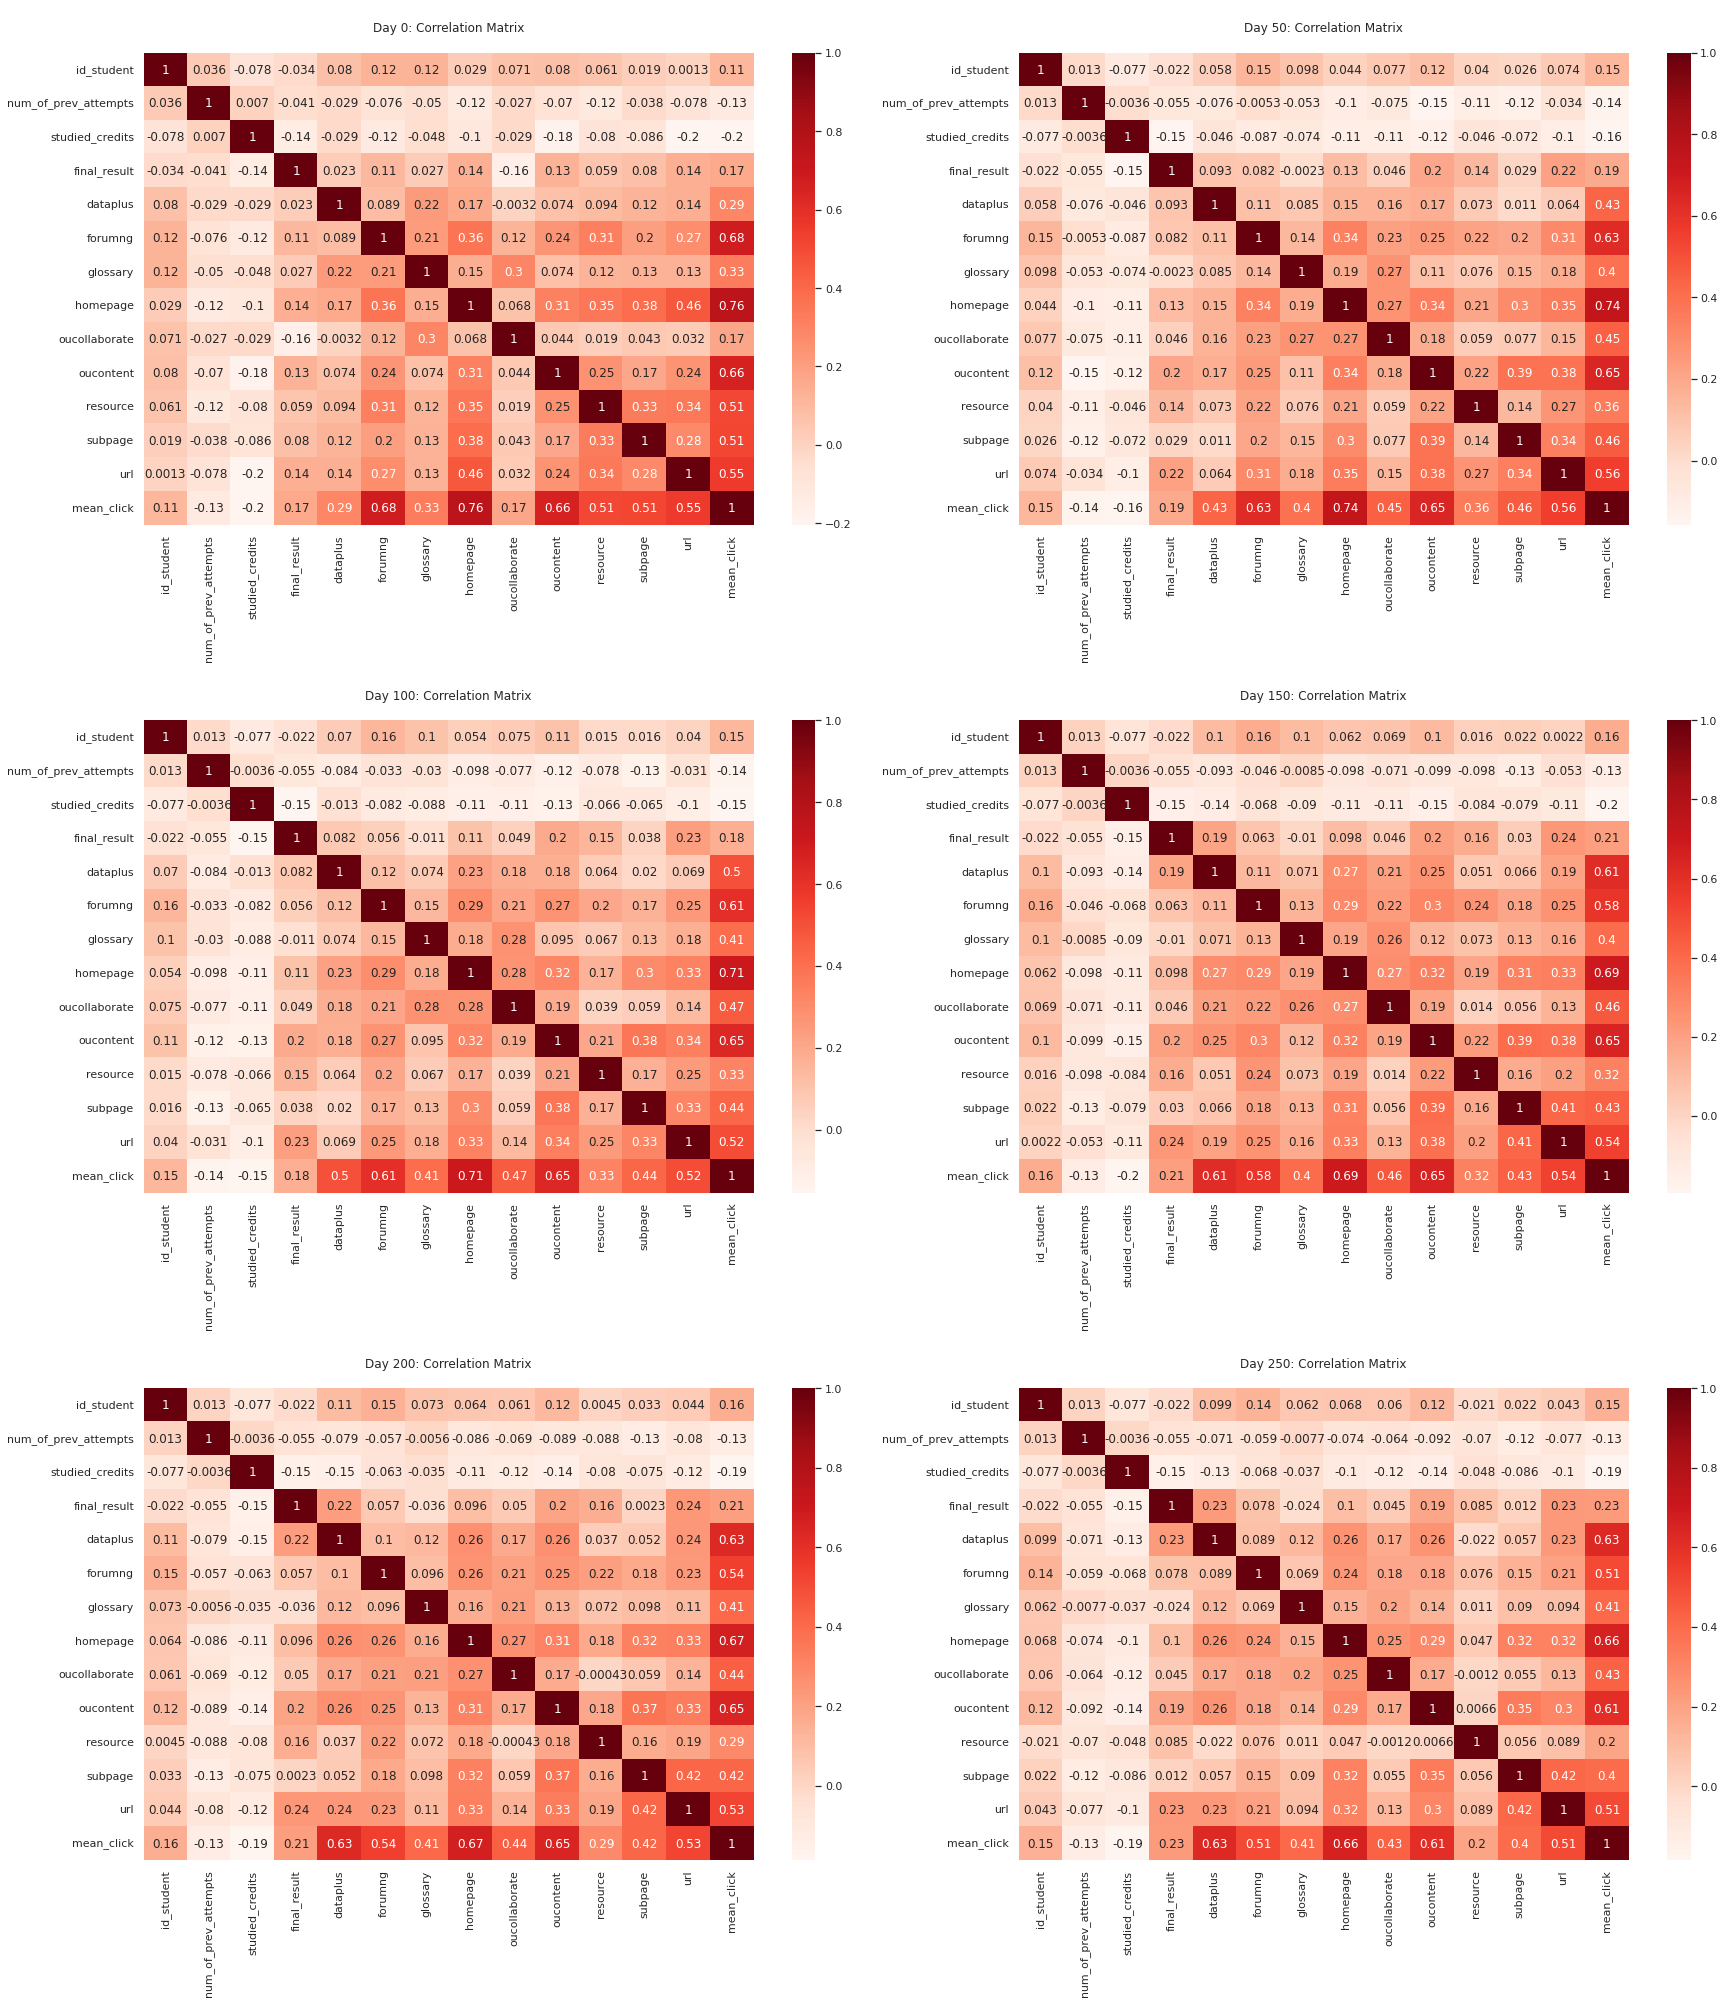

In [21]:
plot_correlation_matrix(df)

### Day 0

In [22]:
df[0] = df[0].drop(columns=['id_student', 'num_of_prev_attempts', 'dataplus', 'glossary', 'resource', 'subpage'])

### Day 50

In [23]:
df[50] = df[50].drop(columns=['id_student', 'num_of_prev_attempts', 'dataplus', 'forumng', 'glossary', 'oucollaborate', 'subpage'])

### Day 100

In [24]:
df[100] = df[100].drop(columns=['id_student', 'num_of_prev_attempts', 'dataplus', 'forumng', 'glossary', 'oucollaborate', 'subpage'])

### Day 150

In [25]:
df[150] = df[150].drop(columns=['id_student', 'num_of_prev_attempts', 'forumng', 'glossary', 'homepage', 'oucollaborate', 'subpage'])

### Day 200

In [26]:
df[200] = df[200].drop(columns=['id_student', 'num_of_prev_attempts', 'forumng', 'glossary', 'homepage', 'oucollaborate', 'subpage'])

### Day 250

In [27]:
df[250] = df[250].drop(columns=['id_student', 'num_of_prev_attempts', 'forumng', 'glossary', 'oucollaborate', 'resource', 'subpage'])

## Make predictions

### 2013J predictions

#### Prepare data for prediction

##### Encode data

In [28]:
df[0].code_presentation.value_counts()

2013J    296
2014J    274
Name: code_presentation, dtype: int64

In [29]:
# X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], ["2013J", "2013B", "2014B"],"2014J")

X_train, X_test, Y_train, Y_test = {},{},{},{}

for i in df.keys():
  X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset_single_presentation(df[i], "2013J")


In [30]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

cat_cols = ['highest_education','imd_band','age_band','gender','region','disability']
numerical_cols = ['num_of_prev_attempts','studied_credits','dataplus','forumng','glossary','homepage','oucollaborate','oucontent','resource','subpage','url','mean_click']

preprocessing_transformer = make_column_transformer(
        (OneHotEncoder(), cat_cols),
        remainder=StandardScaler())
        #(StandardScaler(), numerical_cols))

In [31]:
for i in df.keys():

  X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
              columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
              index=X_train[i].index)

  X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
              columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
              index=X_test[i].index)

##### Undersampling

In [32]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
original dataset shape: Counter({1: 193, 0: 29})
Resample dataset shape Counter({0: 29, 1: 29})
Sampling for day 50
original dataset shape: Counter({1: 199, 0: 32})
Resample dataset shape Counter({0: 32, 1: 32})
Sampling for day 100
original dataset shape: Counter({1: 199, 0: 32})
Resample dataset shape Counter({0: 32, 1: 32})
Sampling for day 150
original dataset shape: Counter({1: 199, 0: 32})
Resample dataset shape Counter({0: 32, 1: 32})
Sampling for day 200
original dataset shape: Counter({1: 199, 0: 32})
Resample dataset shape Counter({0: 32, 1: 32})
Sampling for day 250
original dataset shape: Counter({1: 199, 0: 32})
Resample dataset shape Counter({0: 32, 1: 32})


#### Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [34]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [35]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [36]:
result = []

##### Day 0

In [37]:
day = 0

###### Random Search

In [38]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [39]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [40]:
# rf_random.best_params_

###### Grid Search

In [41]:
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [False],
#     'max_depth': [50, 60, 70, 80],
#     'max_features': ['sqrt'],
#     'min_samples_leaf': [1,2,3],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# grid_search.fit(X_train_sample[day], Y_train_sample[day])

In [42]:
# print('Model Performance:')

# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate_search(best_grid, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [43]:
# grid_search.best_params_

###### Prediction

In [44]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 30,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,
                            min_samples_split= 5,
                            n_estimators= 400,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 0:
Accuracy: 0.6621621621621622, F1 Score: 0.7863247863247863, Precision: 0.9019607843137255, Recall: 0.696969696969697


In [45]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.446513,0.553487,1.0
1,0.344124,0.655876,0.0
2,0.792413,0.207587,1.0
3,0.405219,0.594781,1.0
4,0.775637,0.224363,1.0
...,...,...,...
69,0.620316,0.379684,1.0
70,0.114594,0.885406,1.0
71,0.127370,0.872630,1.0
72,0.429432,0.570568,1.0


##### Day 50

In [46]:
day = 50

###### Random Search

In [47]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [48]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [49]:
# rf_random.best_params_

###### Prediction

In [50]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 20,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,
                            min_samples_split= 2,
                            n_estimators= 1000,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 50:
Accuracy: 0.6666666666666666, F1 Score: 0.7678571428571429, Precision: 0.9555555555555556, Recall: 0.6417910447761194


In [51]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.335,0.665,1.0
1,0.412,0.588,1.0
2,0.550,0.450,1.0
3,0.767,0.233,0.0
4,0.294,0.706,1.0
...,...,...,...
73,0.580,0.420,1.0
74,0.606,0.394,1.0
75,0.456,0.544,1.0
76,0.434,0.566,1.0


##### Day 100

In [52]:
day = 100

###### Random Search

In [53]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [54]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [55]:
# rf_random.best_params_

###### Prediction

In [56]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 10,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,
                            min_samples_split= 5,
                            n_estimators= 2000,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 100:
Accuracy: 0.6410256410256411, F1 Score: 0.75, Precision: 0.9333333333333333, Recall: 0.6268656716417911


In [57]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.297522,0.702478,1.0
1,0.581809,0.418191,1.0
2,0.404988,0.595012,1.0
3,0.584493,0.415507,0.0
4,0.210206,0.789794,1.0
...,...,...,...
73,0.606352,0.393648,1.0
74,0.646735,0.353265,1.0
75,0.342561,0.657439,1.0
76,0.295855,0.704145,1.0


##### Day 150

In [58]:
day = 150

###### Random Search

In [59]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [60]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [61]:
# rf_random.best_params_

###### Prediction

In [62]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 10,
                            max_features= 'auto',
                            min_samples_leaf= 1,
                            min_samples_split= 5,
                            n_estimators= 1600,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 150:
Accuracy: 0.717948717948718, F1 Score: 0.810344827586207, Precision: 0.9591836734693877, Recall: 0.7014925373134329


In [63]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.367525,0.632475,1.0
1,0.676827,0.323173,1.0
2,0.302024,0.697976,1.0
3,0.822579,0.177421,0.0
4,0.310080,0.689920,1.0
...,...,...,...
73,0.710634,0.289366,1.0
74,0.457043,0.542957,1.0
75,0.400877,0.599123,1.0
76,0.492532,0.507468,1.0


##### Day 200

In [64]:
day = 200

###### Random Search

In [65]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [66]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [67]:
# rf_random.best_params_

###### Prediction

In [68]:
rf = RandomForestClassifier(bootstrap= False,
                            max_depth= 70,
                            max_features= 'auto',
                            min_samples_leaf= 2,
                            min_samples_split= 5,
                            n_estimators= 600,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 200:
Accuracy: 0.6923076923076923, F1 Score: 0.7894736842105263, Precision: 0.9574468085106383, Recall: 0.6716417910447762


In [69]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.197385,0.802615,1.0
1,0.601482,0.398518,1.0
2,0.295959,0.704041,1.0
3,0.886525,0.113475,0.0
4,0.333881,0.666119,1.0
...,...,...,...
73,0.719627,0.280373,1.0
74,0.782089,0.217911,1.0
75,0.559904,0.440096,1.0
76,0.283467,0.716533,1.0


##### Day 250

In [70]:
day = 250

###### Random Search

In [71]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [72]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [73]:
# rf_random.best_params_

###### Prediction

In [74]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 80,
                            max_features= 'sqrt',
                            min_samples_leaf= 4,
                            min_samples_split= 5,
                            n_estimators= 1400,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 250:
Accuracy: 0.7307692307692307, F1 Score: 0.8235294117647058, Precision: 0.9423076923076923, Recall: 0.7313432835820896


In [75]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.392721,0.607279,1.0
1,0.666836,0.333164,1.0
2,0.357555,0.642445,1.0
3,0.766248,0.233752,0.0
4,0.435479,0.564521,1.0
...,...,...,...
73,0.736657,0.263343,1.0
74,0.678219,0.321781,1.0
75,0.548600,0.451400,1.0
76,0.476322,0.523678,1.0


##### Overall Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


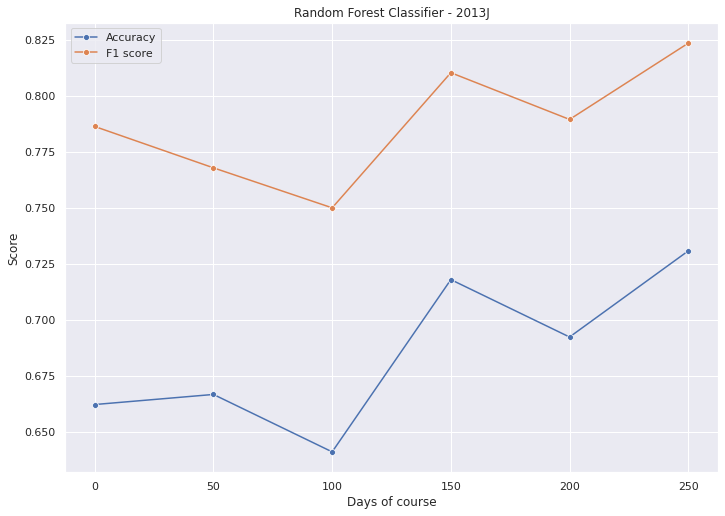

In [76]:
plot_days(df.keys(),result, "Random Forest Classifier - 2013J")

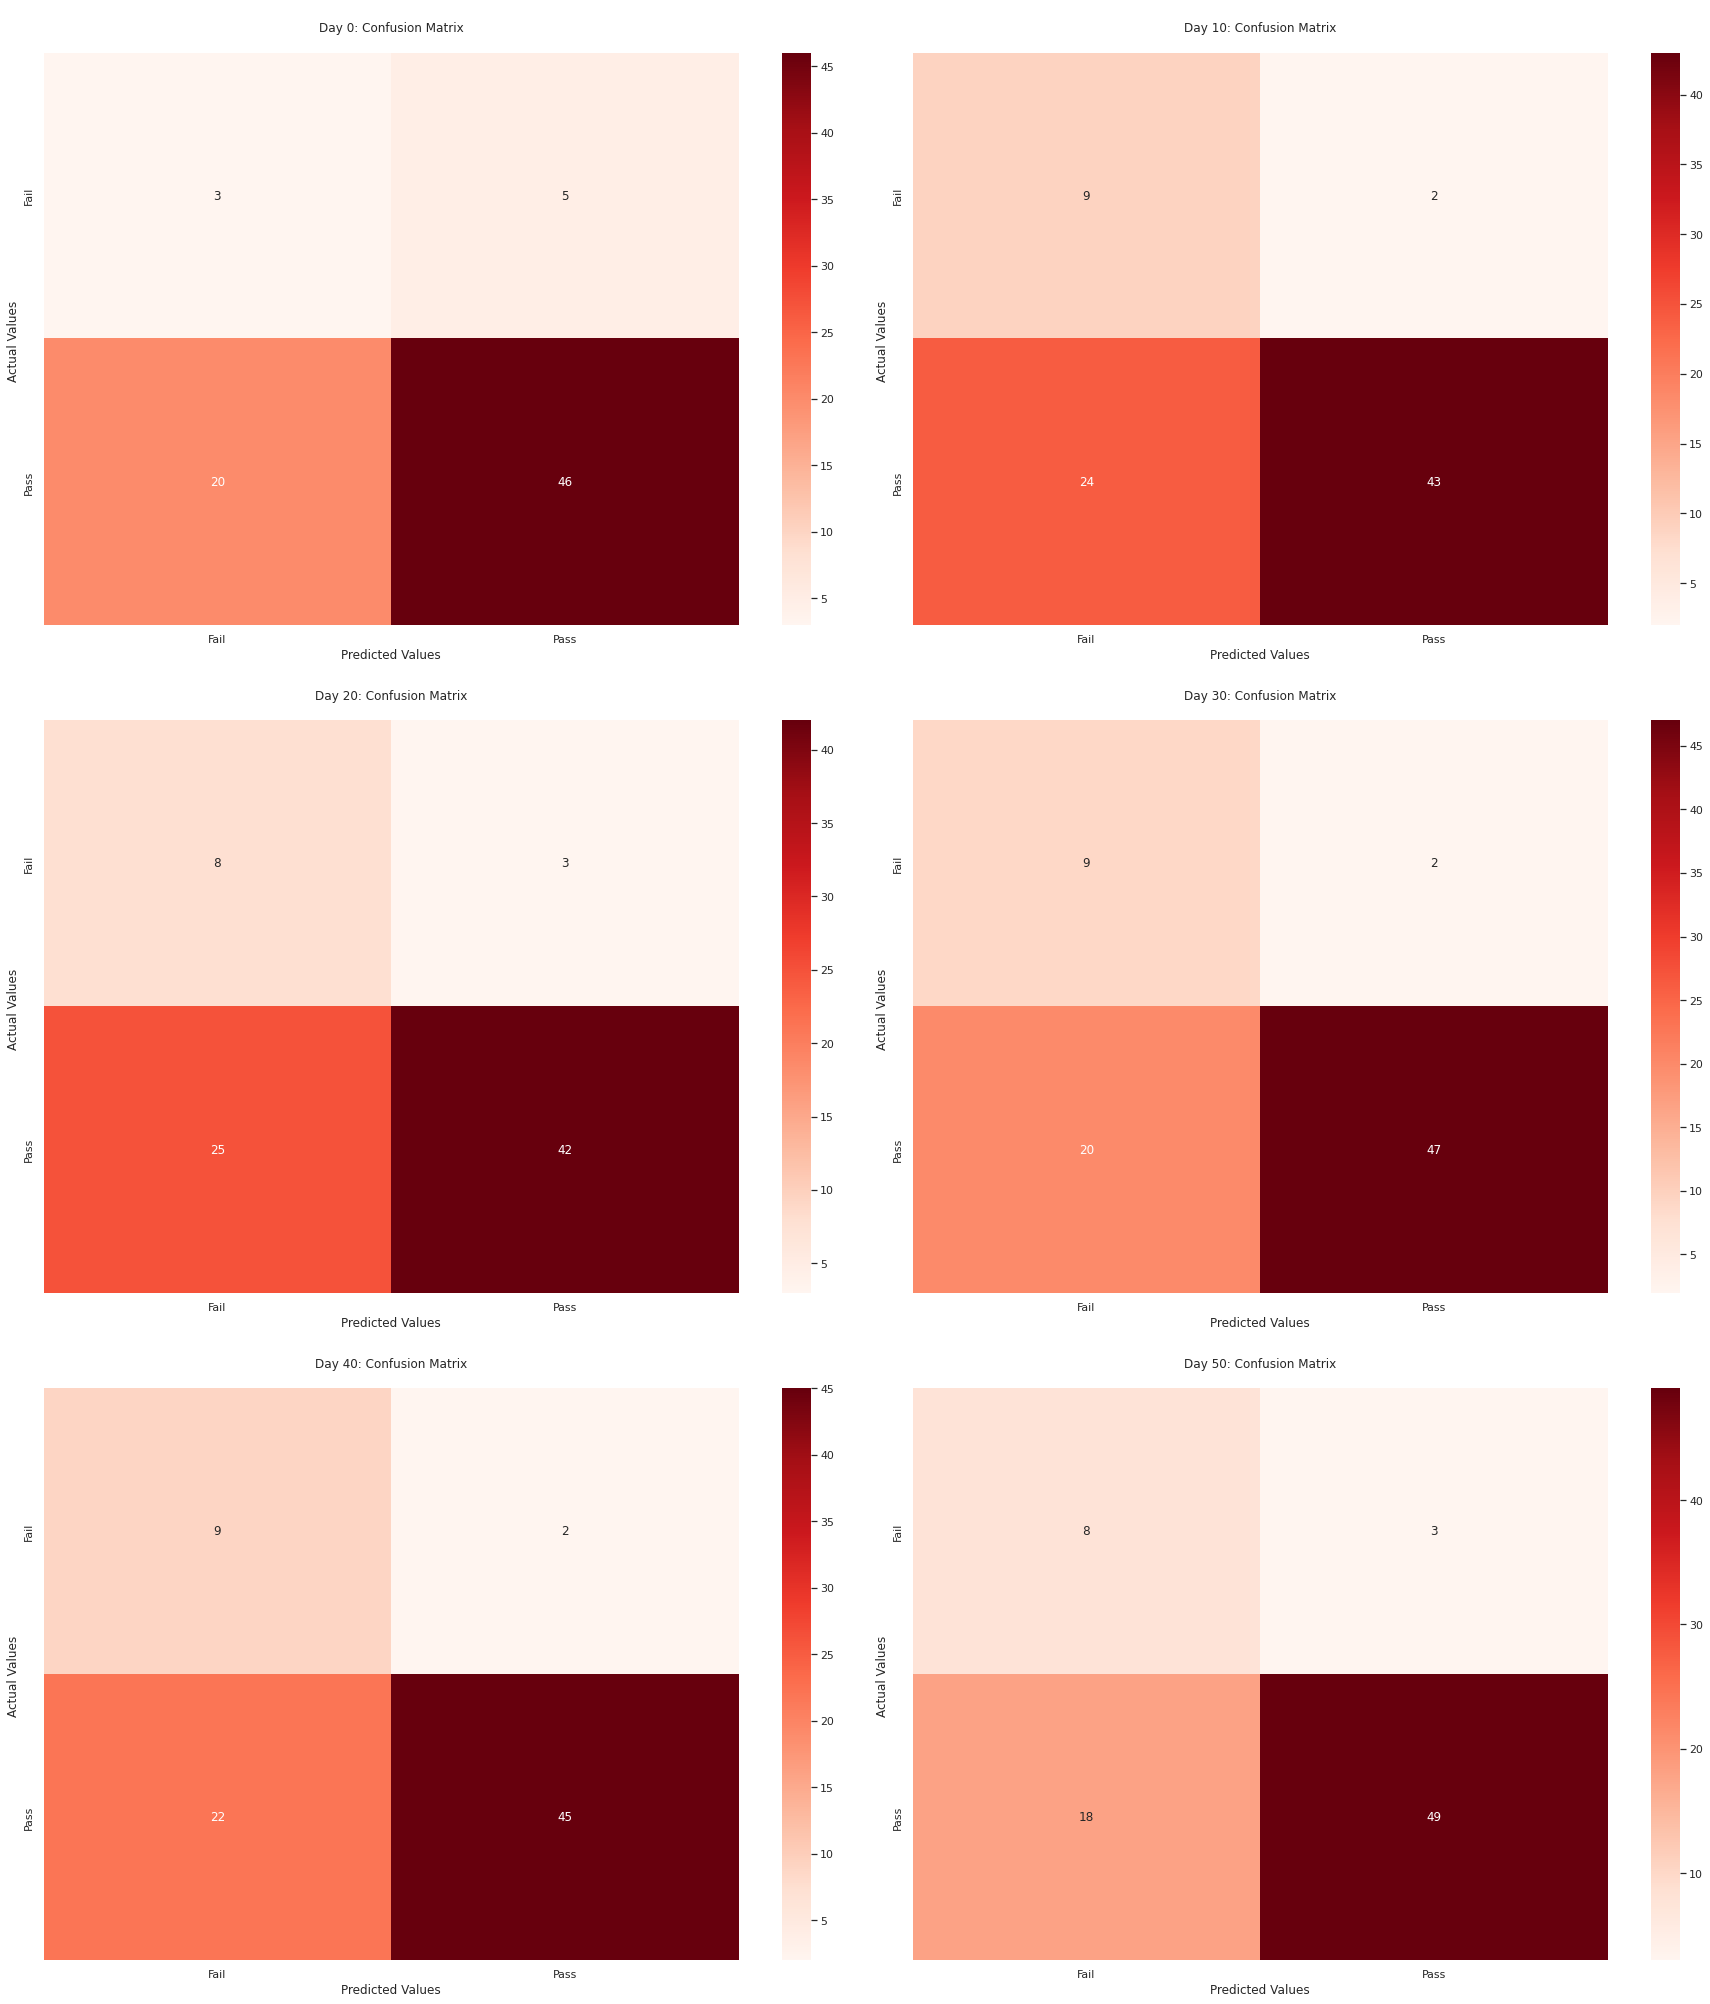

In [77]:
plot_confusion_matrix(result)

In [78]:
# !pip install shap

In [79]:
# import shap 

In [80]:
# shap_values = shap.TreeExplainer(grid_search.best_estimator_).shap_values(X_train_sample[250])
# shap.summary_plot(shap_values, X_train_sample[250])

In [81]:
# explainer = shap.TreeExplainer(grid_search.best_estimator_)

In [82]:
# shap.initjs()

# # Write in a function
# def shap_plot(j):
#   explainerModel = shap.TreeExplainer(grid_search.best_estimator_)
#   shap_values_Model = explainerModel.shap_values(S)
#   p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
#   return(p)

#### Naive Bayes

In [83]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [84]:
var_smoothing = [0.0000001, 0.00000001, 0.000000001, 0.00000001]

In [85]:
# Create the random grid
param_grid = {'var_smoothing': var_smoothing}

In [86]:
result = []

##### Day 0

In [87]:
day = 0

###### Grid Search

In [88]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [89]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.80%, F1 Score = 0.88%.
Accuracy = 0.74%, F1 Score = 0.85%.
Improvement of -6.78%.


In [90]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [91]:
nb = GaussianNB(var_smoothing=1e-08)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 0:
Accuracy: 0.7702702702702703, F1 Score: 0.8640000000000001, Precision: 0.9152542372881356, Recall: 0.8181818181818182


In [92]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,1.091929e-12,1.000000,1.0
1,1.728298e-07,1.000000,0.0
2,4.616726e-08,1.000000,1.0
3,4.362504e-04,0.999564,1.0
4,2.781561e-05,0.999972,1.0
...,...,...,...
69,1.243575e-09,1.000000,1.0
70,4.935254e-13,1.000000,1.0
71,2.966603e-08,1.000000,1.0
72,3.365944e-04,0.999663,1.0


##### Day 50

In [93]:
day = 50

###### Grid Search

In [94]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [95]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.81%, F1 Score = 0.89%.
Accuracy = 0.79%, F1 Score = 0.88%.
Improvement of -1.59%.


In [96]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [97]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 50:
Accuracy: 0.7948717948717948, F1 Score: 0.8823529411764706, Precision: 0.8695652173913043, Recall: 0.8955223880597015


In [98]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,6.581294e-07,0.999999,1.0
1,3.812738e-11,1.000000,1.0
2,7.802380e-04,0.999220,1.0
3,1.556384e-01,0.844362,0.0
4,1.328957e-10,1.000000,1.0
...,...,...,...
73,8.325042e-02,0.916750,1.0
74,4.703929e-09,1.000000,1.0
75,1.246069e-07,1.000000,1.0
76,1.265655e-02,0.987343,1.0


##### Day 100

In [99]:
day = 100

###### Grid Search

In [100]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [101]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.62%, F1 Score = 0.73%.
Accuracy = 0.62%, F1 Score = 0.73%.
Improvement of 0.00%.


In [102]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [103]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 100:
Accuracy: 0.6153846153846154, F1 Score: 0.7272727272727273, Precision: 0.9302325581395349, Recall: 0.5970149253731343


In [104]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,9.060683e-01,9.393175e-02,1.0
1,8.015393e-01,1.984607e-01,1.0
2,4.350264e-04,9.995650e-01,1.0
3,9.999996e-01,4.253159e-07,0.0
4,4.019334e-08,1.000000e+00,1.0
...,...,...,...
73,4.606374e-01,5.393626e-01,1.0
74,9.509276e-01,4.907236e-02,1.0
75,2.384409e-03,9.976156e-01,1.0
76,1.137116e-03,9.988629e-01,1.0


##### Day 150

In [105]:
day = 150

###### Grid Search

In [106]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [107]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.73%, F1 Score = 0.84%.
Accuracy = 0.71%, F1 Score = 0.82%.
Improvement of -3.51%.


In [108]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [109]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 150:
Accuracy: 0.7051282051282052, F1 Score: 0.8160000000000001, Precision: 0.8793103448275862, Recall: 0.7611940298507462


In [110]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,4.025257e-04,0.999597,1.0
1,1.261895e-10,1.000000,1.0
2,7.417704e-10,1.000000,1.0
3,9.977152e-01,0.002285,0.0
4,1.065126e-11,1.000000,1.0
...,...,...,...
73,8.171711e-01,0.182829,1.0
74,1.766291e-10,1.000000,1.0
75,2.338912e-08,1.000000,1.0
76,2.925591e-06,0.999997,1.0


##### Day 200

In [111]:
day = 200

###### Grid Search

In [112]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [113]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.73%, F1 Score = 0.84%.
Accuracy = 0.72%, F1 Score = 0.83%.
Improvement of -1.75%.


In [114]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [115]:
nb = GaussianNB(var_smoothing=1e-08)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 200:
Accuracy: 0.717948717948718, F1 Score: 0.8307692307692308, Precision: 0.8571428571428571, Recall: 0.8059701492537313


In [116]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,1.003833e-11,1.000000,1.0
1,2.701324e-14,1.000000,1.0
2,1.585697e-13,1.000000,1.0
3,5.656171e-04,0.999434,0.0
4,1.000000e+00,0.000000,1.0
...,...,...,...
73,5.837241e-11,1.000000,1.0
74,8.128424e-13,1.000000,1.0
75,1.518348e-05,0.999985,1.0
76,1.919427e-12,1.000000,1.0


##### Day 250

In [117]:
day = 250

###### Grid Search

In [118]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [119]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.74%, F1 Score = 0.84%.
Accuracy = 0.74%, F1 Score = 0.84%.
Improvement of 0.00%.


In [120]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [121]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 250:
Accuracy: 0.7435897435897436, F1 Score: 0.84375, Precision: 0.8852459016393442, Recall: 0.8059701492537313


In [122]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,3.715213e-14,1.0,1.0
1,1.000000e+00,0.0,1.0
2,2.202824e-13,1.0,1.0
3,4.353873e-08,1.0,0.0
4,9.024339e-16,1.0,1.0
...,...,...,...
73,1.232974e-10,1.0,1.0
74,1.000000e+00,0.0,1.0
75,2.955365e-13,1.0,1.0
76,1.026942e-11,1.0,1.0


##### Overall Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


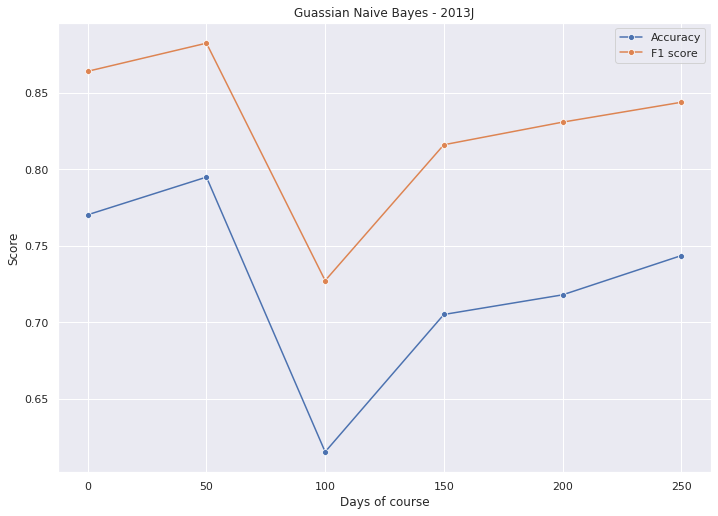

In [123]:
plot_days(df.keys(),result, "Guassian Naive Bayes - 2013J")

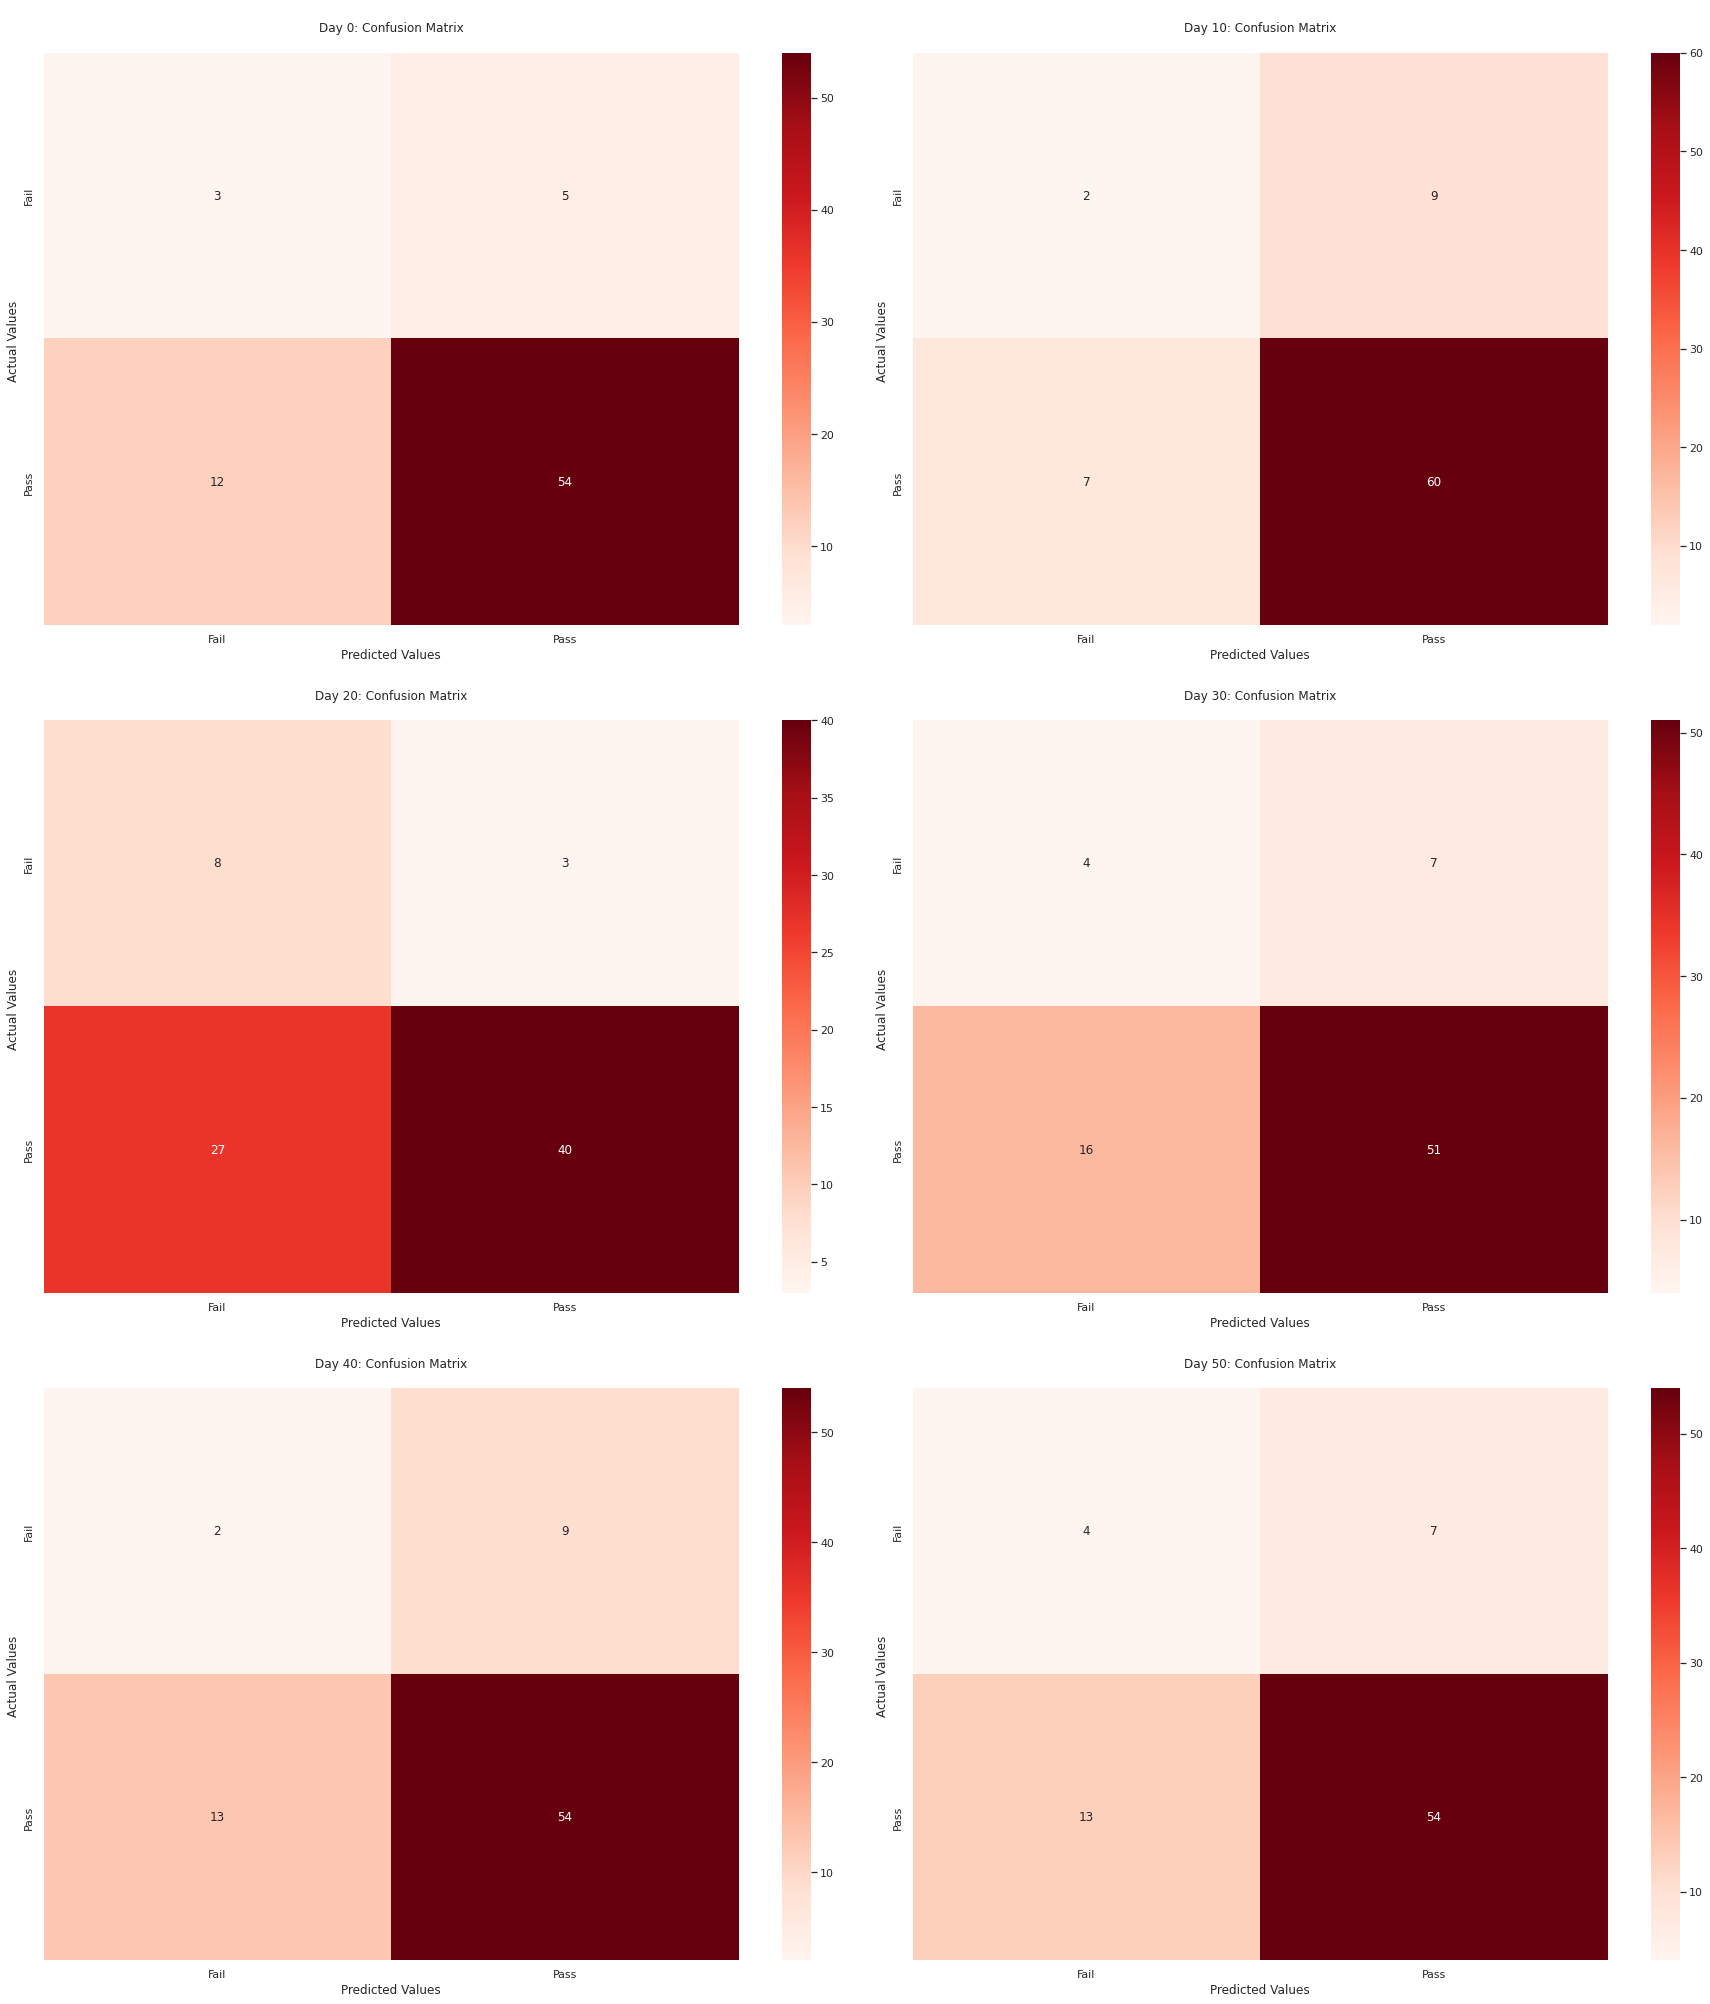

In [124]:
plot_confusion_matrix(result)

#### K-Nearest Neighbors

In [125]:
from sklearn.neighbors import KNeighborsClassifier

In [126]:
leaf_size = list(range(1,50, 2))
n_neighbors = list(range(1,31))
p=[1,2]

In [127]:
#Create the random grid
param_grid = {'leaf_size': leaf_size,
              'n_neighbors': n_neighbors,
              'p': p}


# param_grid = {'n_neighbors': n_neighbors}

In [128]:
result = []

##### Day 0

In [129]:
day = 0

###### Random Search

In [130]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [131]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [132]:
# knn_random.best_params_

###### Prediction

In [133]:
knn = KNeighborsClassifier()

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 0:
Accuracy: 0.7027027027027027, F1 Score: 0.8070175438596493, Precision: 0.9583333333333334, Recall: 0.696969696969697


In [134]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.4,0.6,1.0
1,0.6,0.4,0.0
2,0.8,0.2,1.0
3,0.2,0.8,1.0
4,0.6,0.4,1.0
...,...,...,...
69,0.6,0.4,1.0
70,0.0,1.0,1.0
71,0.2,0.8,1.0
72,0.2,0.8,1.0


##### Day 50

In [135]:
day = 50

###### Random Search

In [136]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [137]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [138]:
# knn_random.best_params_

###### Prediction

In [139]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=8, p=1)

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 50:
Accuracy: 0.717948717948718, F1 Score: 0.819672131147541, Precision: 0.9090909090909091, Recall: 0.746268656716418


In [140]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.250,0.750,1.0
1,0.500,0.500,1.0
2,0.375,0.625,1.0
3,0.625,0.375,0.0
4,0.250,0.750,1.0
...,...,...,...
73,0.625,0.375,1.0
74,0.250,0.750,1.0
75,0.375,0.625,1.0
76,0.375,0.625,1.0


##### Day 100

In [141]:
day = 100

###### Random Search

In [142]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [143]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [144]:
# knn_random.best_params_

###### Prediction

In [145]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=21, p=2)

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 100:
Accuracy: 0.7051282051282052, F1 Score: 0.8130081300813009, Precision: 0.8928571428571429, Recall: 0.746268656716418


In [146]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.285714,0.714286,1.0
1,0.571429,0.428571,1.0
2,0.428571,0.571429,1.0
3,0.666667,0.333333,0.0
4,0.238095,0.761905,1.0
...,...,...,...
73,0.571429,0.428571,1.0
74,0.523810,0.476190,1.0
75,0.476190,0.523810,1.0
76,0.285714,0.714286,1.0


##### Day 150

In [147]:
day = 150

###### Random Search

In [148]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [149]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [150]:
# knn_random.best_params_

###### Prediction

In [151]:
knn = KNeighborsClassifier()

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 150:
Accuracy: 0.7564102564102564, F1 Score: 0.8455284552845529, Precision: 0.9285714285714286, Recall: 0.7761194029850746


In [152]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.2,0.8,1.0
1,0.8,0.2,1.0
2,0.2,0.8,1.0
3,0.6,0.4,0.0
4,0.2,0.8,1.0
...,...,...,...
73,0.6,0.4,1.0
74,0.2,0.8,1.0
75,0.2,0.8,1.0
76,0.4,0.6,1.0


##### Day 200

In [153]:
day = 200

###### Random Search

In [154]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [155]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [156]:
# knn_random.best_params_

###### Prediction

In [157]:
knn = KNeighborsClassifier()

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 200:
Accuracy: 0.6923076923076923, F1 Score: 0.7966101694915254, Precision: 0.9215686274509803, Recall: 0.7014925373134329


In [158]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.0,1.0,1.0
1,0.6,0.4,1.0
2,0.2,0.8,1.0
3,0.8,0.2,0.0
4,0.2,0.8,1.0
...,...,...,...
73,0.8,0.2,1.0
74,0.8,0.2,1.0
75,0.6,0.4,1.0
76,0.4,0.6,1.0


##### Day 250

In [159]:
day = 250

###### Random Search

In [160]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [161]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [162]:
# knn_random.best_params_

###### Prediction

In [163]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=7, p=2)

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 250:
Accuracy: 0.5897435897435898, F1 Score: 0.7142857142857142, Precision: 0.8888888888888888, Recall: 0.5970149253731343


In [164]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.142857,0.857143,1.0
1,0.571429,0.428571,1.0
2,0.142857,0.857143,1.0
3,0.571429,0.428571,0.0
4,0.571429,0.428571,1.0
...,...,...,...
73,0.714286,0.285714,1.0
74,0.428571,0.571429,1.0
75,0.571429,0.428571,1.0
76,0.714286,0.285714,1.0


##### Overall Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


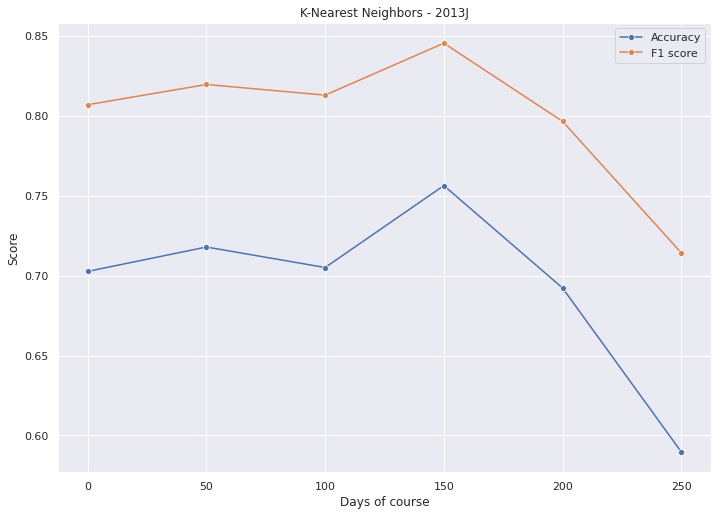

In [165]:
plot_days(df.keys(),result, "K-Nearest Neighbors - 2013J")

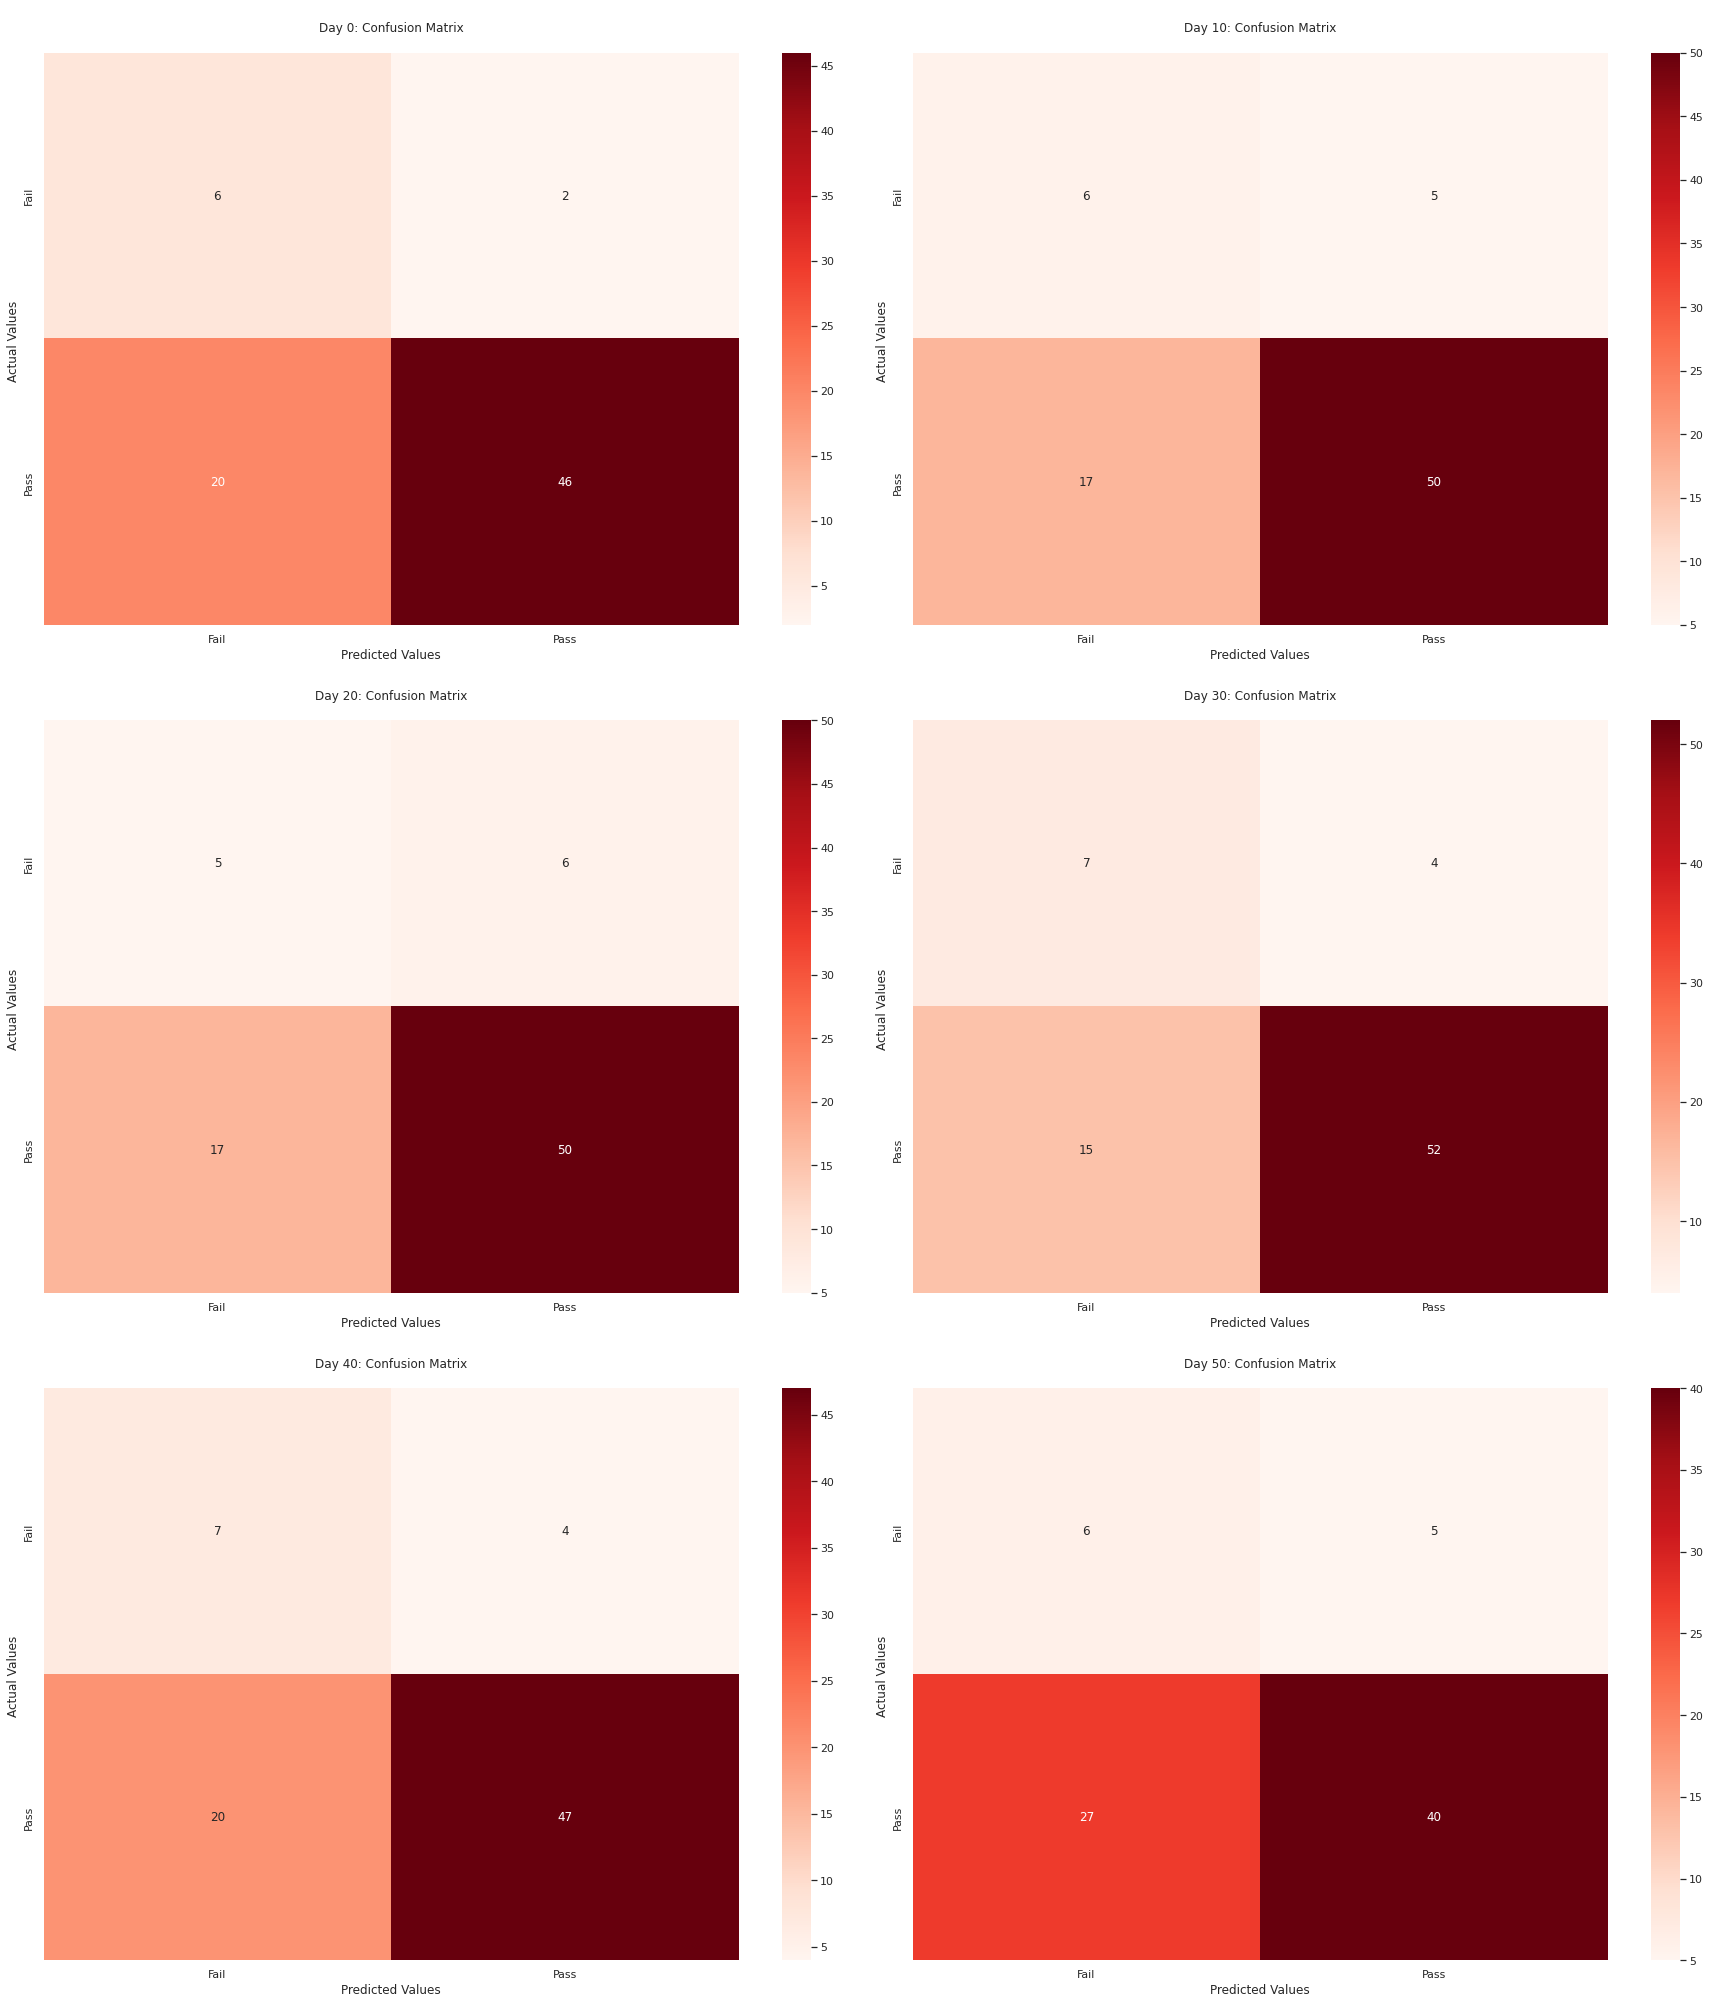

In [166]:
plot_confusion_matrix(result)

### 2014J Predictions

#### Prepare data for prediction

##### Encode data

In [167]:
df[0].code_presentation.value_counts()

2013J    296
2014J    274
Name: code_presentation, dtype: int64

In [168]:
# X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], ["2013J", "2013B", "2014B"],"2014J")

X_train, X_test, Y_train, Y_test = {},{},{},{}

for i in df.keys():
  X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset_single_presentation(df[i], "2014J")


In [169]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

cat_cols = ['highest_education','imd_band','age_band','gender','region','disability']
numerical_cols = ['num_of_prev_attempts','studied_credits','dataplus','forumng','glossary','homepage','oucollaborate','oucontent','resource','subpage','url','mean_click']

preprocessing_transformer = make_column_transformer(
        (OneHotEncoder(), cat_cols),
        remainder=StandardScaler())
        #(StandardScaler(), numerical_cols))

In [170]:
for i in df.keys():

  X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
              columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
              index=X_train[i].index)

  X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
              columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
              index=X_test[i].index)

##### Undersampling

In [171]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
original dataset shape: Counter({1: 172, 0: 33})
Resample dataset shape Counter({0: 33, 1: 33})
Sampling for day 50
original dataset shape: Counter({1: 184, 0: 35})
Resample dataset shape Counter({0: 35, 1: 35})
Sampling for day 100
original dataset shape: Counter({1: 184, 0: 35})
Resample dataset shape Counter({0: 35, 1: 35})
Sampling for day 150
original dataset shape: Counter({1: 184, 0: 35})
Resample dataset shape Counter({0: 35, 1: 35})
Sampling for day 200
original dataset shape: Counter({1: 184, 0: 35})
Resample dataset shape Counter({0: 35, 1: 35})
Sampling for day 250
original dataset shape: Counter({1: 184, 0: 35})
Resample dataset shape Counter({0: 35, 1: 35})


#### Random Forest Classifier

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [173]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [174]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [175]:
result = []

##### Day 0

In [176]:
day = 0

###### Random Search

In [177]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [178]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [179]:
# rf_random.best_params_

###### Grid Search

In [180]:
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [False],
#     'max_depth': [50, 60, 70, 80],
#     'max_features': ['sqrt'],
#     'min_samples_leaf': [1,2,3],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# grid_search.fit(X_train_sample[day], Y_train_sample[day])

In [181]:
# print('Model Performance:')

# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate_search(best_grid, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [182]:
# grid_search.best_params_

###### Prediction

In [183]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 30,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,
                            min_samples_split= 5,
                            n_estimators= 400,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 0:
Accuracy: 0.6376811594202898, F1 Score: 0.7524752475247525, Precision: 0.9743589743589743, Recall: 0.6129032258064516


In [184]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.537654,0.462346,1.0
1,0.477480,0.522520,1.0
2,0.871231,0.128769,1.0
3,0.430682,0.569318,1.0
4,0.749862,0.250138,1.0
...,...,...,...
64,0.195521,0.804479,1.0
65,0.572982,0.427018,1.0
66,0.477098,0.522902,1.0
67,0.421089,0.578911,1.0


##### Day 50

In [185]:
day = 50

###### Random Search

In [186]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [187]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [188]:
# rf_random.best_params_

###### Prediction

In [189]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 20,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,
                            min_samples_split= 2,
                            n_estimators= 1000,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 50:
Accuracy: 0.5616438356164384, F1 Score: 0.6799999999999999, Precision: 0.8947368421052632, Recall: 0.5483870967741935


In [190]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.565,0.435,1.0
1,0.365,0.635,1.0
2,0.233,0.767,0.0
3,0.454,0.546,1.0
4,0.291,0.709,1.0
...,...,...,...
68,0.465,0.535,0.0
69,0.610,0.390,1.0
70,0.306,0.694,1.0
71,0.501,0.499,0.0


##### Day 100

In [191]:
day = 100

###### Random Search

In [192]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [193]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [194]:
# rf_random.best_params_

###### Prediction

In [195]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 10,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,
                            min_samples_split= 5,
                            n_estimators= 2000,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 100:
Accuracy: 0.6027397260273972, F1 Score: 0.7184466019417476, Precision: 0.9024390243902439, Recall: 0.5967741935483871


In [196]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.690598,0.309402,1.0
1,0.322167,0.677833,1.0
2,0.273380,0.726620,0.0
3,0.314304,0.685696,1.0
4,0.389812,0.610188,1.0
...,...,...,...
68,0.723359,0.276641,0.0
69,0.392428,0.607572,1.0
70,0.411637,0.588363,1.0
71,0.549474,0.450526,0.0


##### Day 150

In [197]:
day = 150

###### Random Search

In [198]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [199]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [200]:
# rf_random.best_params_

###### Prediction

In [201]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 10,
                            max_features= 'auto',
                            min_samples_leaf= 1,
                            min_samples_split= 5,
                            n_estimators= 1600,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 150:
Accuracy: 0.5616438356164384, F1 Score: 0.6666666666666666, Precision: 0.9411764705882353, Recall: 0.5161290322580645


In [202]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.687725,0.312275,1.0
1,0.217353,0.782647,1.0
2,0.589829,0.410171,0.0
3,0.157464,0.842536,1.0
4,0.285976,0.714024,1.0
...,...,...,...
68,0.724273,0.275727,0.0
69,0.616505,0.383495,1.0
70,0.619343,0.380657,1.0
71,0.662218,0.337782,0.0


##### Day 200

In [203]:
day = 200

###### Random Search

In [204]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [205]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [206]:
# rf_random.best_params_

###### Prediction

In [207]:
rf = RandomForestClassifier(bootstrap= False,
                            max_depth= 70,
                            max_features= 'auto',
                            min_samples_leaf= 2,
                            min_samples_split= 5,
                            n_estimators= 600,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 200:
Accuracy: 0.6986301369863014, F1 Score: 0.7999999999999999, Precision: 0.9166666666666666, Recall: 0.7096774193548387


In [208]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.317608,0.682392,1.0
1,0.186376,0.813624,1.0
2,0.387530,0.612470,0.0
3,0.131272,0.868728,1.0
4,0.208006,0.791994,1.0
...,...,...,...
68,0.731854,0.268146,0.0
69,0.241362,0.758638,1.0
70,0.237686,0.762314,1.0
71,0.643683,0.356317,0.0


##### Day 250

In [209]:
day = 250

###### Random Search

In [210]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [211]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [212]:
# rf_random.best_params_

###### Prediction

In [213]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 80,
                            max_features= 'sqrt',
                            min_samples_leaf= 4,
                            min_samples_split= 5,
                            n_estimators= 1400,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 250:
Accuracy: 0.6164383561643836, F1 Score: 0.7358490566037735, Precision: 0.8863636363636364, Recall: 0.6290322580645161


In [214]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.734601,0.265399,1.0
1,0.171630,0.828370,1.0
2,0.459778,0.540222,0.0
3,0.270254,0.729746,1.0
4,0.199890,0.800110,1.0
...,...,...,...
68,0.644424,0.355576,0.0
69,0.360235,0.639765,1.0
70,0.325318,0.674682,1.0
71,0.464956,0.535044,0.0


##### Overall Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


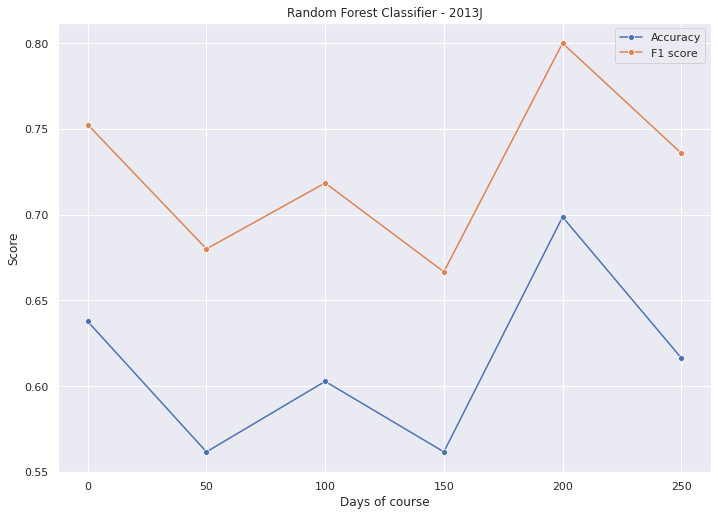

In [215]:
plot_days(df.keys(),result, "Random Forest Classifier - 2013J")

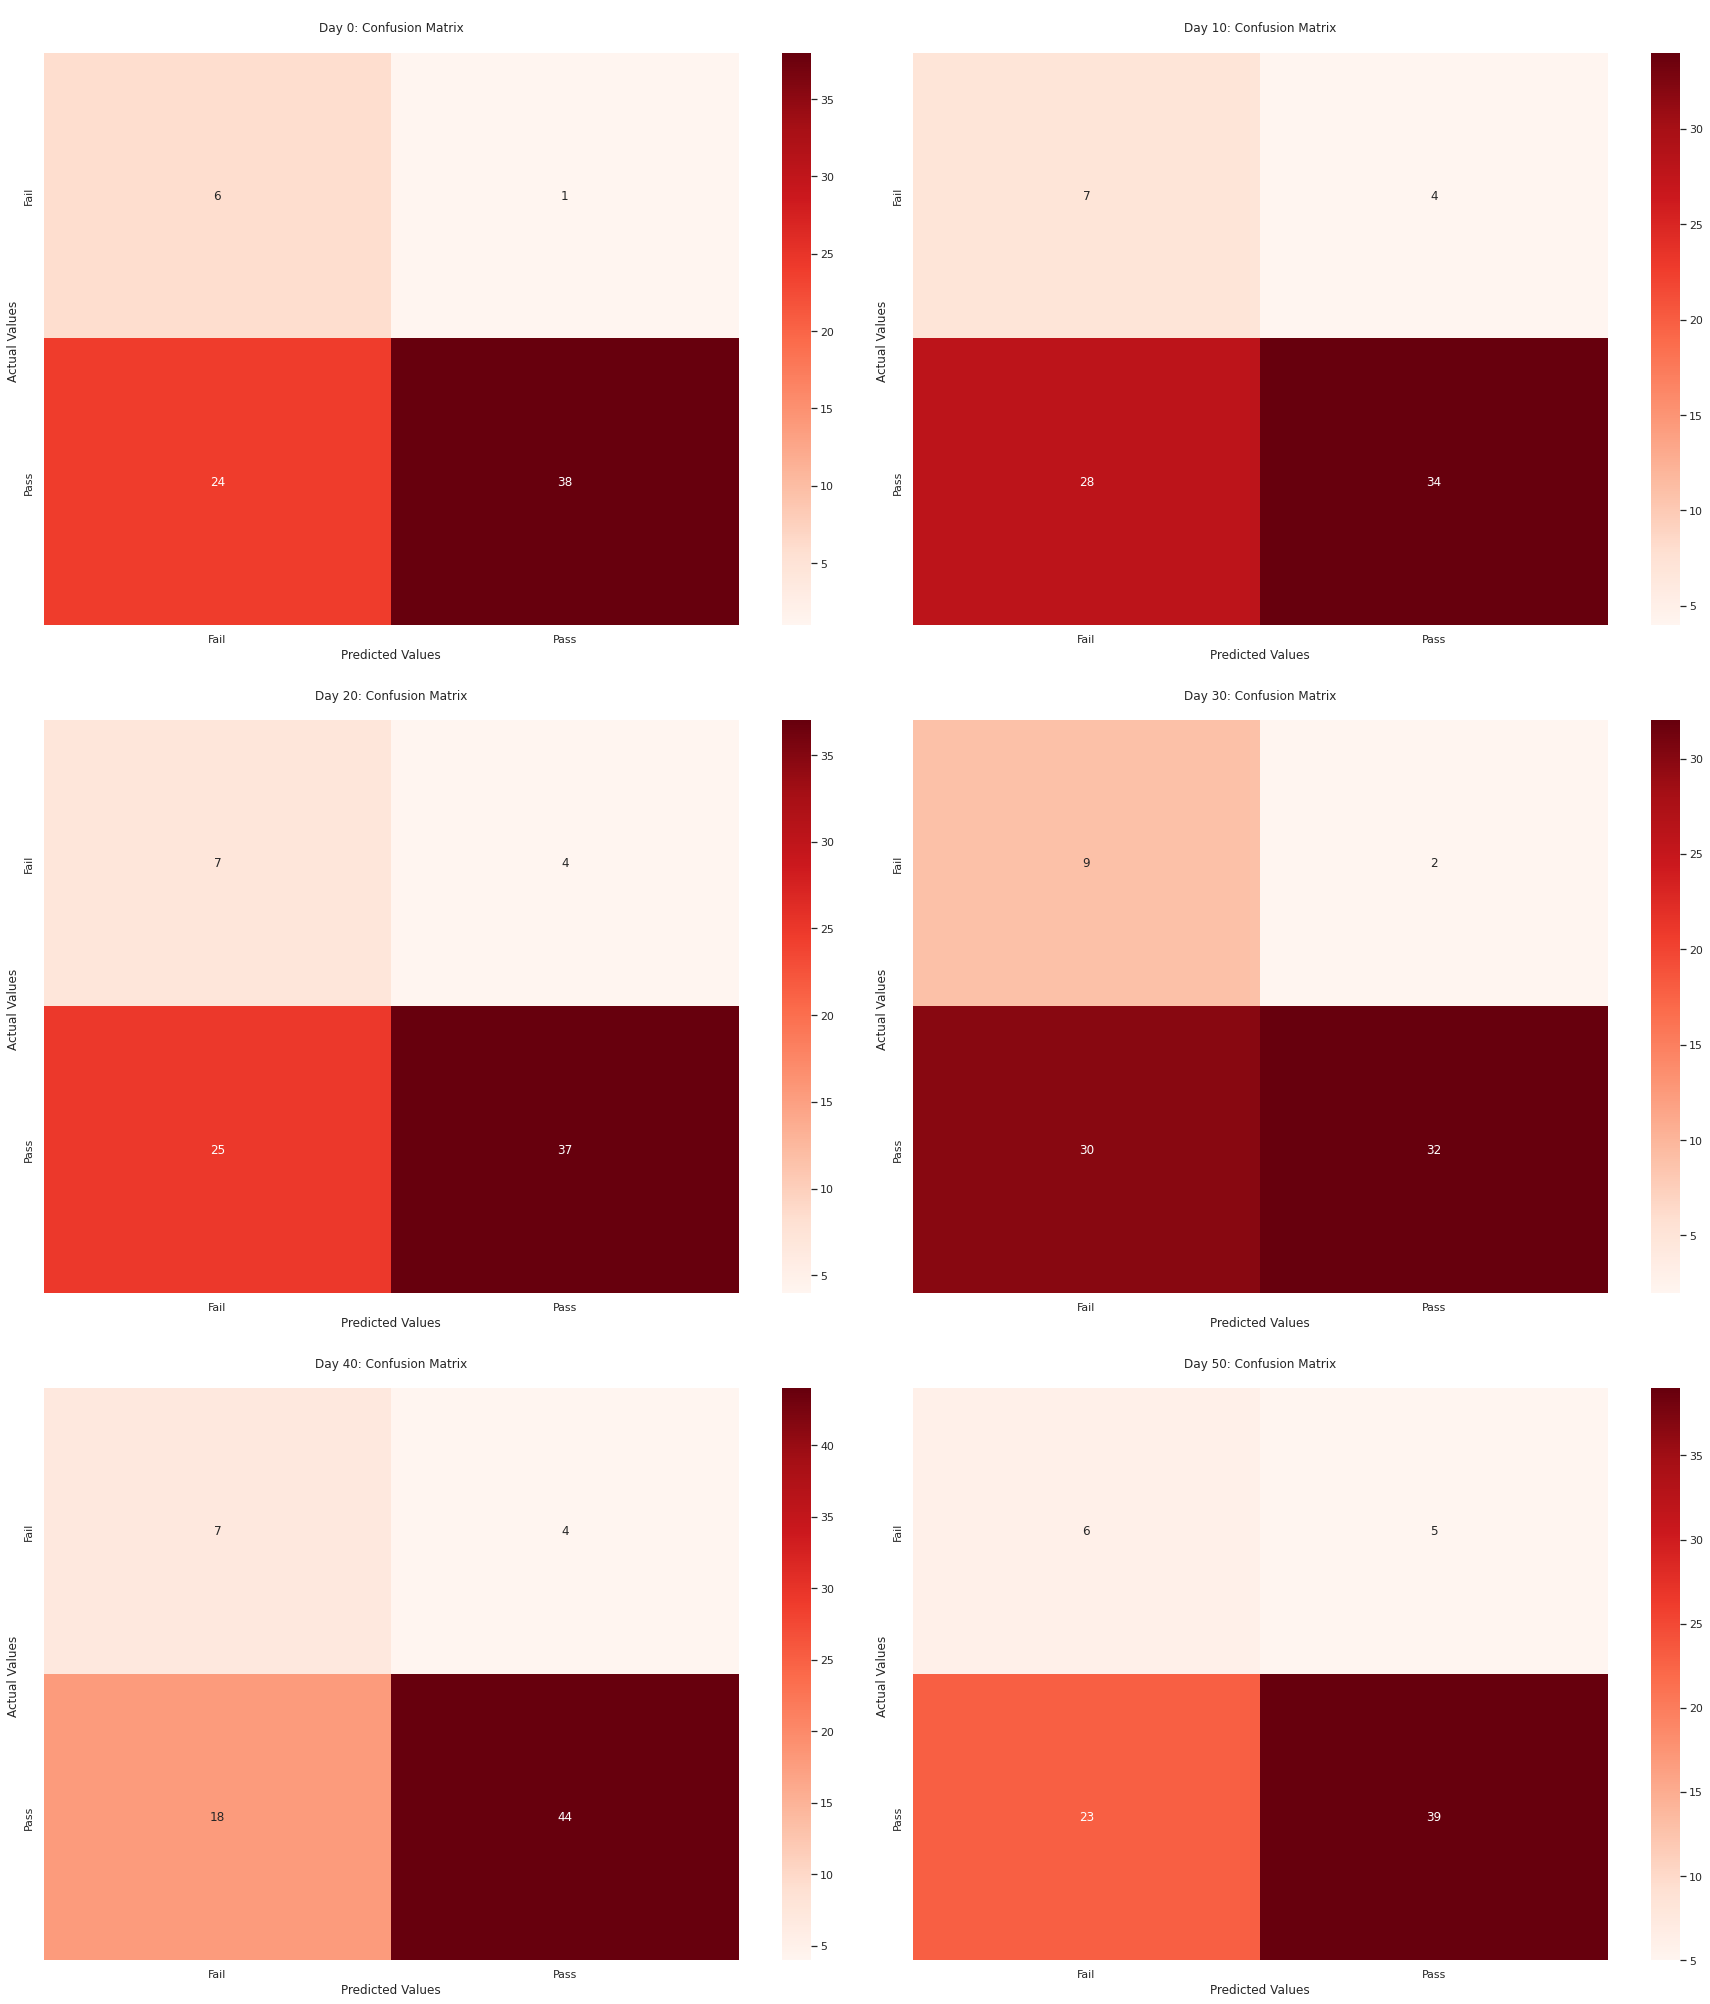

In [216]:
plot_confusion_matrix(result)

In [217]:
# !pip install shap

In [218]:
# import shap 

In [219]:
# shap_values = shap.TreeExplainer(grid_search.best_estimator_).shap_values(X_train_sample[250])
# shap.summary_plot(shap_values, X_train_sample[250])

In [220]:
# explainer = shap.TreeExplainer(grid_search.best_estimator_)

In [221]:
# shap.initjs()

# # Write in a function
# def shap_plot(j):
#   explainerModel = shap.TreeExplainer(grid_search.best_estimator_)
#   shap_values_Model = explainerModel.shap_values(S)
#   p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
#   return(p)

#### Naive Bayes

In [222]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [223]:
var_smoothing = [0.0000001, 0.00000001, 0.000000001, 0.00000001]

In [224]:
# Create the random grid
param_grid = {'var_smoothing': var_smoothing}

In [225]:
result = []

##### Day 0

In [226]:
day = 0

###### Grid Search

In [227]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [228]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.74%, F1 Score = 0.84%.
Accuracy = 0.65%, F1 Score = 0.77%.
Improvement of -11.76%.


In [229]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [230]:
nb = GaussianNB(var_smoothing=1e-08)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 0:
Accuracy: 0.6666666666666666, F1 Score: 0.7850467289719625, Precision: 0.9333333333333333, Recall: 0.6774193548387096


In [231]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,5.629052e-01,0.437095,1.0
1,8.429503e-05,0.999916,1.0
2,9.995732e-01,0.000427,1.0
3,7.643848e-01,0.235615,1.0
4,5.917334e-07,0.999999,1.0
...,...,...,...
64,8.716265e-08,1.000000,1.0
65,1.639638e-06,0.999998,1.0
66,1.199316e-10,1.000000,1.0
67,2.956071e-04,0.999704,1.0


##### Day 50

In [232]:
day = 50

###### Grid Search

In [233]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [234]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.75%, F1 Score = 0.85%.
Accuracy = 0.75%, F1 Score = 0.85%.
Improvement of 0.00%.


In [235]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [236]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 50:
Accuracy: 0.7534246575342466, F1 Score: 0.8548387096774194, Precision: 0.8548387096774194, Recall: 0.8548387096774194


In [237]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,8.046367e-06,0.999992,1.0
1,1.000000e+00,0.000000,1.0
2,2.057431e-09,1.000000,0.0
3,1.618468e-05,0.999984,1.0
4,2.213275e-06,0.999998,1.0
...,...,...,...
68,1.000000e+00,0.000000,0.0
69,4.373550e-04,0.999563,1.0
70,9.643619e-08,1.000000,1.0
71,1.000000e+00,0.000000,0.0


##### Day 100

In [238]:
day = 100

###### Grid Search

In [239]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [240]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.51%, F1 Score = 0.65%.
Accuracy = 0.51%, F1 Score = 0.65%.
Improvement of 0.00%.


In [241]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [242]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 100:
Accuracy: 0.5068493150684932, F1 Score: 0.6470588235294118, Precision: 0.825, Recall: 0.532258064516129


In [243]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,8.267088e-01,1.732912e-01,1.0
1,5.184620e-01,4.815380e-01,1.0
2,4.946789e-08,1.000000e+00,0.0
3,1.048456e-02,9.895154e-01,1.0
4,4.276263e-01,5.723737e-01,1.0
...,...,...,...
68,9.999956e-01,4.439909e-06,0.0
69,2.230407e-05,9.999777e-01,1.0
70,5.101092e-01,4.898908e-01,1.0
71,1.000000e+00,1.185450e-12,0.0


##### Day 150

In [244]:
day = 150

###### Grid Search

In [245]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [246]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.64%, F1 Score = 0.77%.
Accuracy = 0.63%, F1 Score = 0.76%.
Improvement of -2.13%.


In [247]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [248]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 150:
Accuracy: 0.6301369863013698, F1 Score: 0.7567567567567567, Precision: 0.8571428571428571, Recall: 0.6774193548387096


In [249]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,2.965527e-03,9.970345e-01,1.0
1,1.245634e-09,1.000000e+00,1.0
2,3.953271e-06,9.999960e-01,0.0
3,7.082527e-08,9.999999e-01,1.0
4,1.431997e-03,9.985680e-01,1.0
...,...,...,...
68,9.999977e-01,2.349316e-06,0.0
69,1.231993e-06,9.999988e-01,1.0
70,5.296889e-03,9.947031e-01,1.0
71,1.000000e+00,8.555647e-11,0.0


##### Day 200

In [250]:
day = 200

###### Grid Search

In [251]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [252]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.70%, F1 Score = 0.81%.
Accuracy = 0.68%, F1 Score = 0.80%.
Improvement of -1.96%.


In [253]:
nb_random.best_params_

{'var_smoothing': 1e-08}

###### Prediction

In [254]:
nb = GaussianNB(var_smoothing=1e-08)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 200:
Accuracy: 0.684931506849315, F1 Score: 0.7964601769911503, Precision: 0.8823529411764706, Recall: 0.7258064516129032


In [255]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,2.068159e-08,1.000000e+00,1.0
1,1.000000e+00,0.000000e+00,1.0
2,1.000000e+00,0.000000e+00,0.0
3,1.131776e-09,1.000000e+00,1.0
4,1.381293e-07,9.999999e-01,1.0
...,...,...,...
68,1.000000e+00,0.000000e+00,0.0
69,2.644531e-12,1.000000e+00,1.0
70,6.465320e-09,1.000000e+00,1.0
71,9.999999e-01,1.303485e-07,0.0


##### Day 250

In [256]:
day = 250

###### Grid Search

In [257]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [258]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.78%, F1 Score = 0.87%.
Accuracy = 0.78%, F1 Score = 0.87%.
Improvement of 0.00%.


In [259]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [260]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 250:
Accuracy: 0.7808219178082192, F1 Score: 0.8666666666666666, Precision: 0.896551724137931, Recall: 0.8387096774193549


In [261]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,4.619467e-05,0.999954,1.0
1,9.409346e-11,1.000000,1.0
2,1.751449e-11,1.000000,0.0
3,2.423058e-10,1.000000,1.0
4,3.215422e-09,1.000000,1.0
...,...,...,...
68,9.965149e-01,0.003485,0.0
69,2.938122e-02,0.970619,1.0
70,2.924059e-08,1.000000,1.0
71,1.559855e-01,0.844015,0.0


##### Overall Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


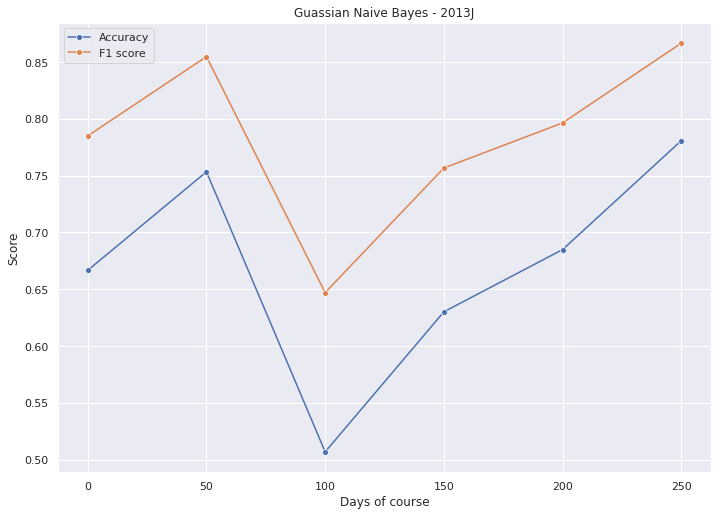

In [262]:
plot_days(df.keys(),result, "Guassian Naive Bayes - 2013J")

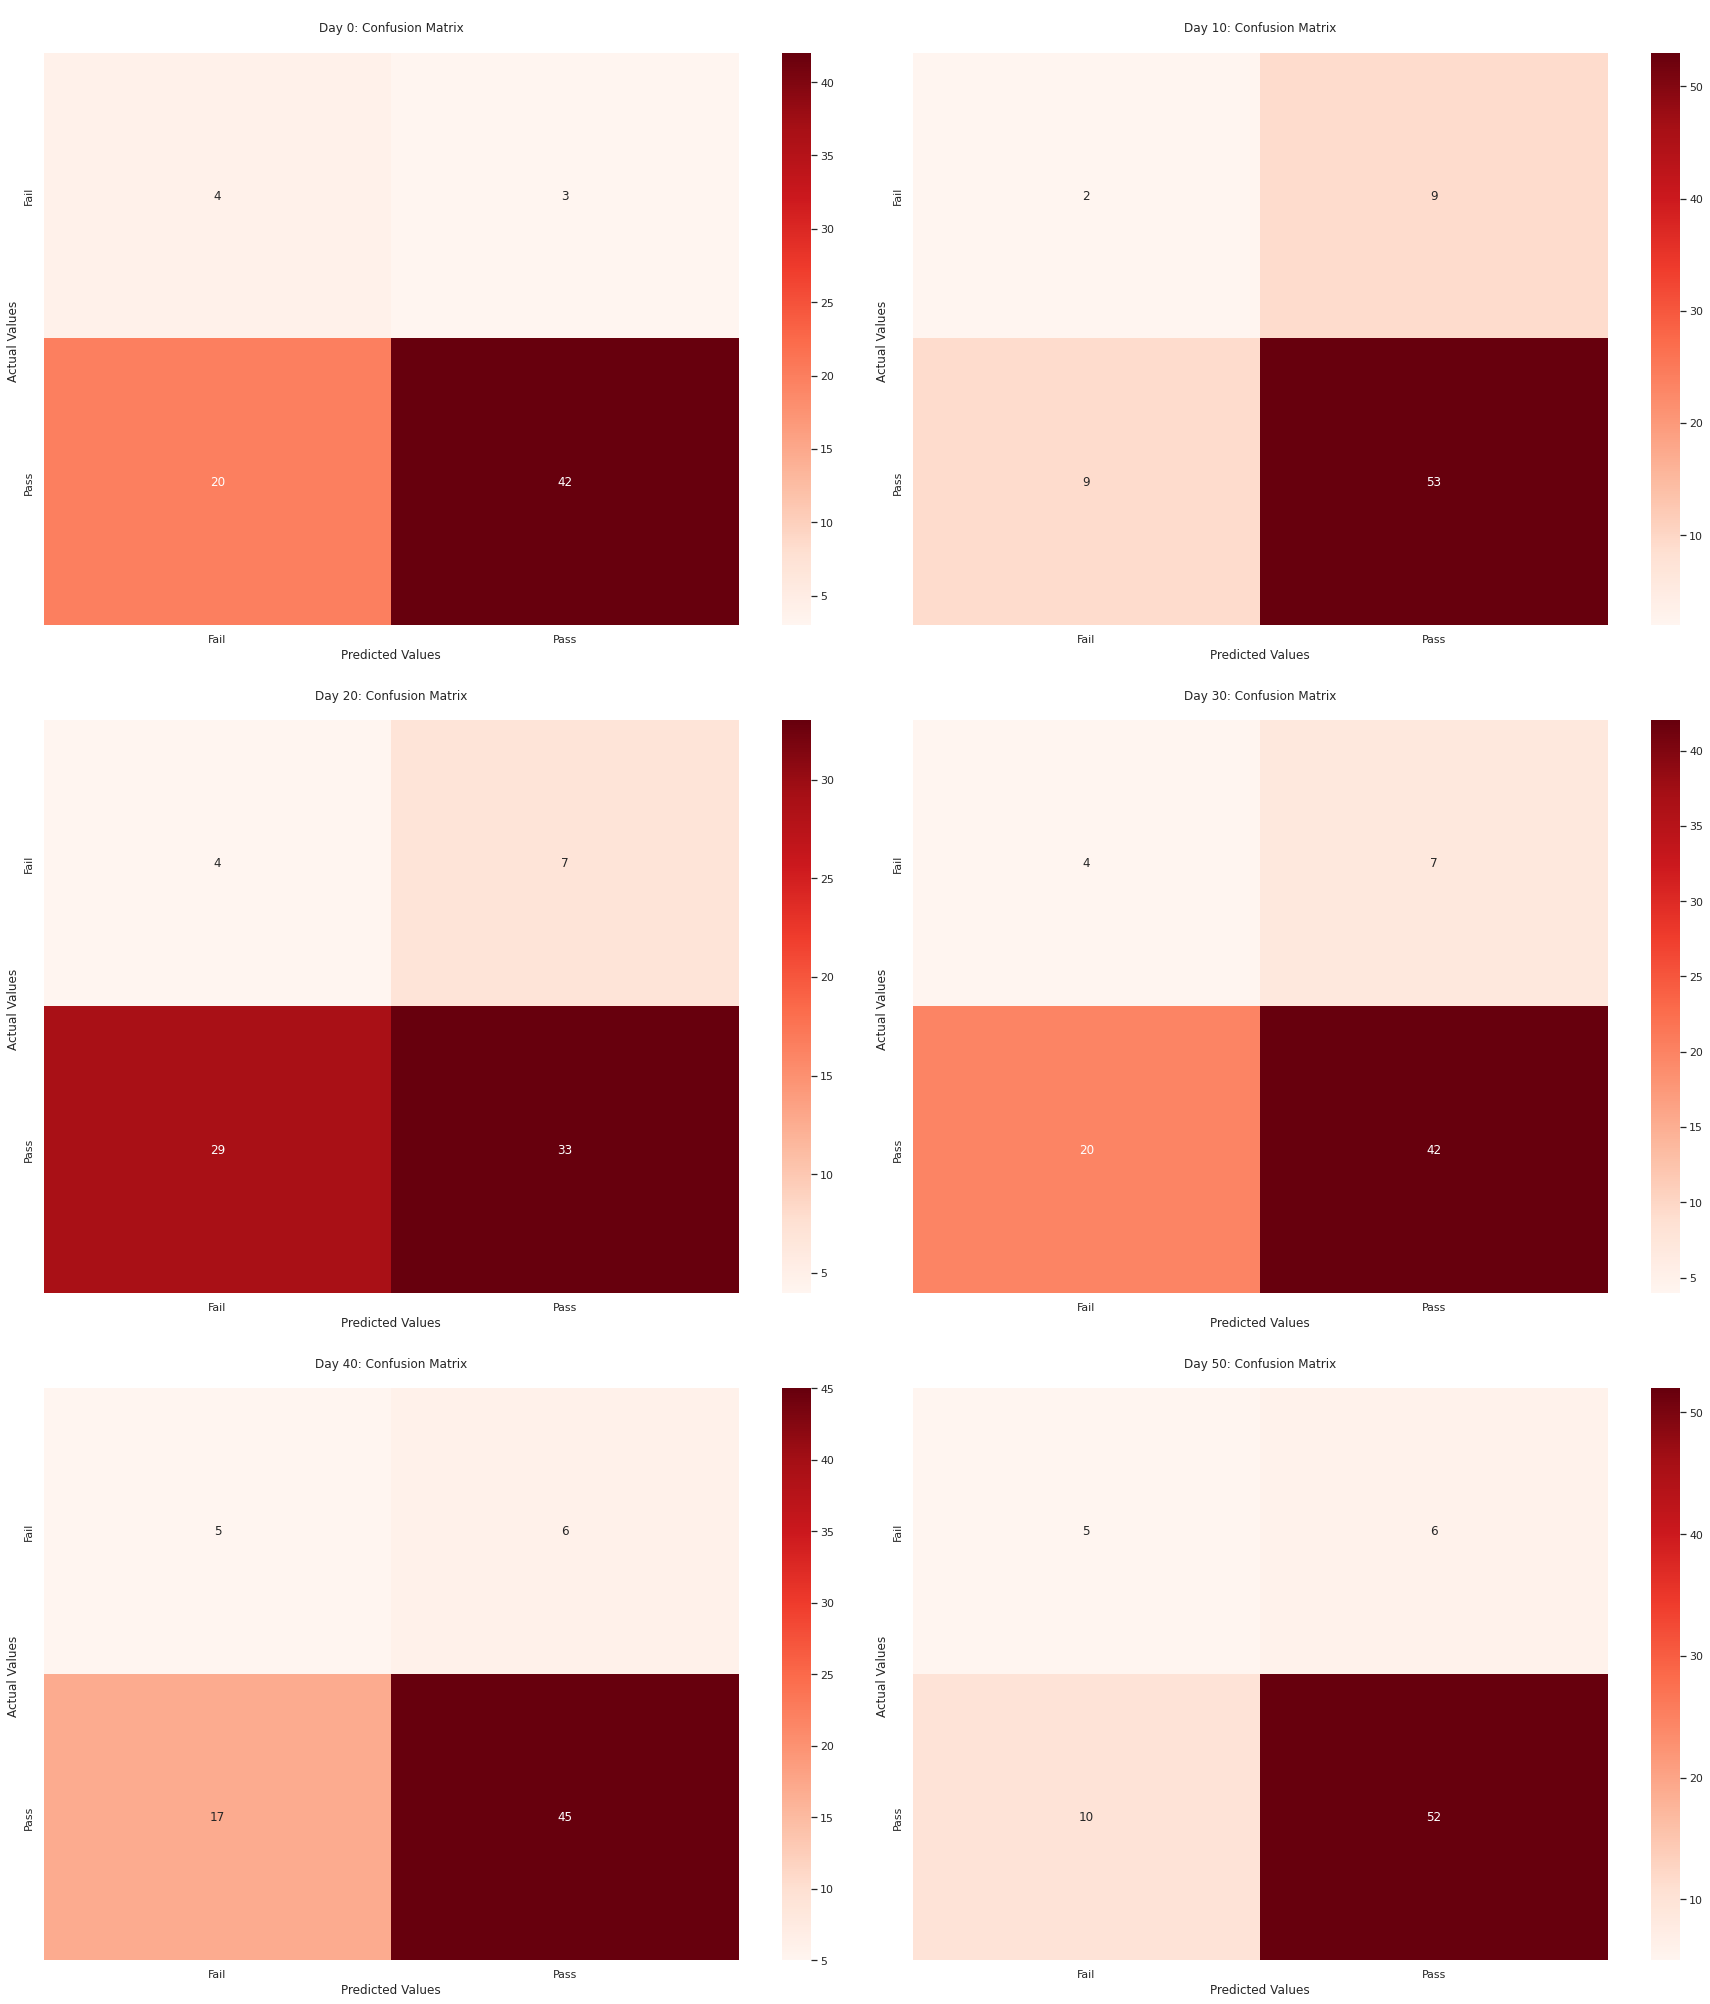

In [263]:
plot_confusion_matrix(result)

#### K-Nearest Neighbors

In [264]:
from sklearn.neighbors import KNeighborsClassifier

In [265]:
leaf_size = list(range(1,50, 2))
n_neighbors = list(range(1,31))
p=[1,2]

In [266]:
#Create the random grid
param_grid = {'leaf_size': leaf_size,
              'n_neighbors': n_neighbors,
              'p': p}


# param_grid = {'n_neighbors': n_neighbors}

In [267]:
result = []

##### Day 0

In [268]:
day = 0

###### Random Search

In [269]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [270]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [271]:
# knn_random.best_params_

###### Prediction

In [272]:
knn = KNeighborsClassifier()

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 0:
Accuracy: 0.6376811594202898, F1 Score: 0.761904761904762, Precision: 0.9302325581395349, Recall: 0.6451612903225806


In [273]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.4,0.6,1.0
1,0.2,0.8,1.0
2,0.6,0.4,1.0
3,0.2,0.8,1.0
4,0.8,0.2,1.0
...,...,...,...
64,0.0,1.0,1.0
65,0.6,0.4,1.0
66,0.4,0.6,1.0
67,0.4,0.6,1.0


##### Day 50

In [274]:
day = 50

###### Random Search

In [275]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [276]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [277]:
# knn_random.best_params_

###### Prediction

In [278]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=8, p=1)

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 50:
Accuracy: 0.4794520547945205, F1 Score: 0.5957446808510638, Precision: 0.875, Recall: 0.45161290322580644


In [279]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.375,0.625,1.0
1,0.375,0.625,1.0
2,0.500,0.500,0.0
3,0.250,0.750,1.0
4,0.375,0.625,1.0
...,...,...,...
68,0.250,0.750,0.0
69,0.500,0.500,1.0
70,0.250,0.750,1.0
71,0.750,0.250,0.0


##### Day 100

In [280]:
day = 100

###### Random Search

In [281]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [282]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [283]:
# knn_random.best_params_

###### Prediction

In [284]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=21, p=2)

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 100:
Accuracy: 0.6986301369863014, F1 Score: 0.8103448275862069, Precision: 0.8703703703703703, Recall: 0.7580645161290323


In [285]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.523810,0.476190,1.0
1,0.428571,0.571429,1.0
2,0.380952,0.619048,0.0
3,0.333333,0.666667,1.0
4,0.333333,0.666667,1.0
...,...,...,...
68,0.571429,0.428571,0.0
69,0.380952,0.619048,1.0
70,0.333333,0.666667,1.0
71,0.476190,0.523810,0.0


##### Day 150

In [286]:
day = 150

###### Random Search

In [287]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [288]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [289]:
# knn_random.best_params_

###### Prediction

In [290]:
knn = KNeighborsClassifier()

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 150:
Accuracy: 0.4931506849315068, F1 Score: 0.6021505376344086, Precision: 0.9032258064516129, Recall: 0.45161290322580644


In [291]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.8,0.2,1.0
1,0.0,1.0,1.0
2,0.8,0.2,0.0
3,0.0,1.0,1.0
4,0.2,0.8,1.0
...,...,...,...
68,0.6,0.4,0.0
69,0.8,0.2,1.0
70,0.8,0.2,1.0
71,0.8,0.2,0.0


##### Day 200

In [292]:
day = 200

###### Random Search

In [293]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [294]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [295]:
# knn_random.best_params_

###### Prediction

In [296]:
knn = KNeighborsClassifier()

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 200:
Accuracy: 0.726027397260274, F1 Score: 0.8245614035087719, Precision: 0.9038461538461539, Recall: 0.7580645161290323


In [297]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.4,0.6,1.0
1,0.0,1.0,1.0
2,0.4,0.6,0.0
3,0.0,1.0,1.0
4,0.4,0.6,1.0
...,...,...,...
68,0.6,0.4,0.0
69,0.0,1.0,1.0
70,0.4,0.6,1.0
71,0.8,0.2,0.0


##### Day 250

In [298]:
day = 250

###### Random Search

In [299]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [300]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [301]:
# knn_random.best_params_

###### Prediction

In [302]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=7, p=2)

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 250:
Accuracy: 0.6164383561643836, F1 Score: 0.7142857142857143, Precision: 0.9722222222222222, Recall: 0.5645161290322581


In [303]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.571429,0.428571,1.0
1,0.000000,1.000000,1.0
2,0.571429,0.428571,0.0
3,0.000000,1.000000,1.0
4,0.000000,1.000000,1.0
...,...,...,...
68,0.714286,0.285714,0.0
69,0.142857,0.857143,1.0
70,0.285714,0.714286,1.0
71,0.714286,0.285714,0.0


##### Overall Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


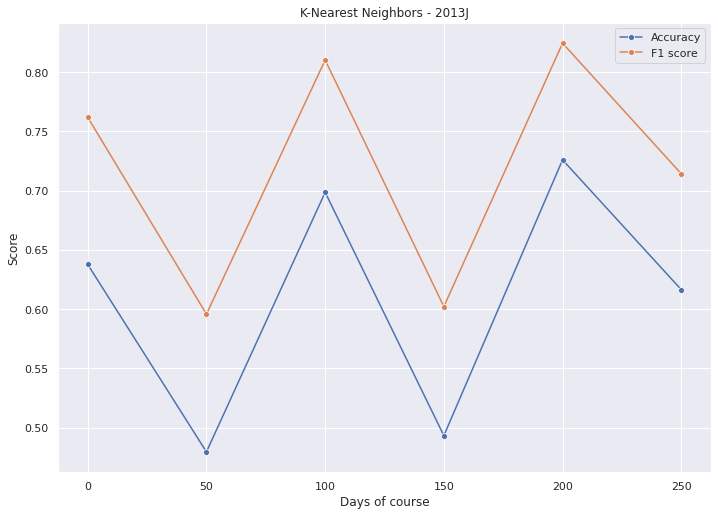

In [304]:
plot_days(df.keys(),result, "K-Nearest Neighbors - 2013J")

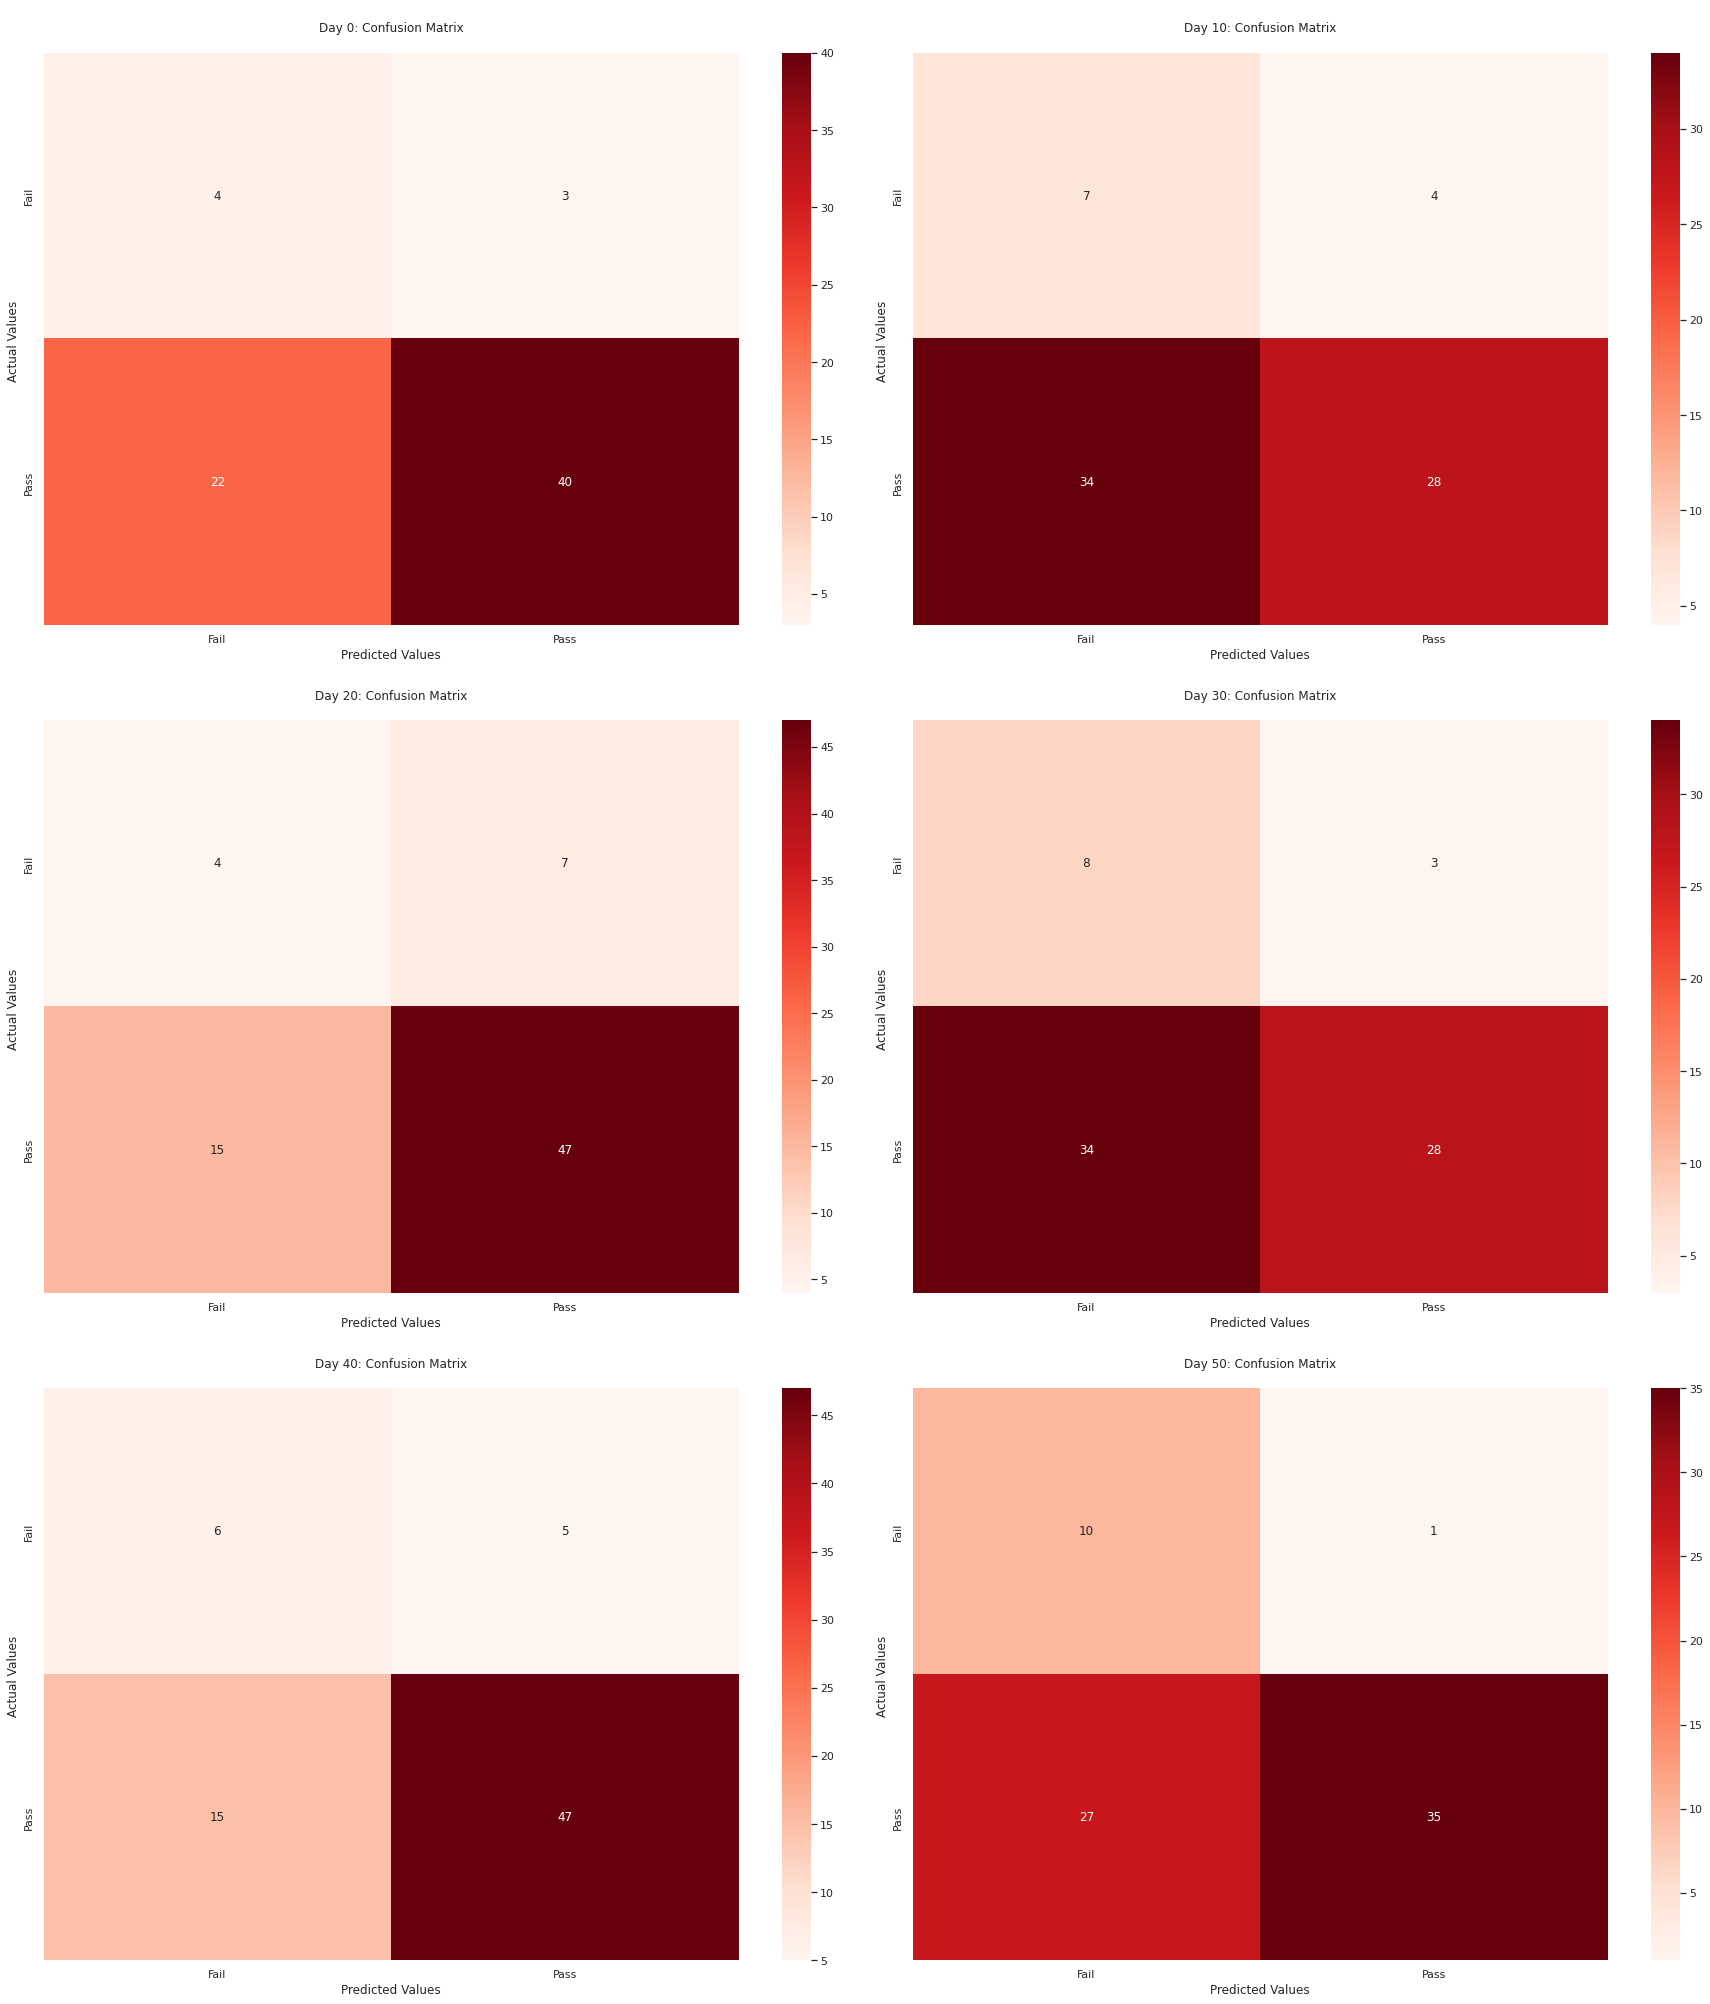

In [305]:
plot_confusion_matrix(result)

### All course presentations

**Train:** 2013J

**Test:** 2014J

#### Prepare data for prediction

##### Encode data

In [306]:
df[0].code_presentation.value_counts()

2013J    296
2014J    274
Name: code_presentation, dtype: int64

In [307]:
X_train, X_test, Y_train, Y_test = {},{},{},{}

for i in df.keys():
  X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], ["2013J"],"2014J")


In [308]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

cat_cols = ['highest_education','imd_band','age_band','gender','region','disability']
numerical_cols = ['num_of_prev_attempts','studied_credits','dataplus','forumng','glossary','homepage','oucollaborate','oucontent','resource','subpage','url','mean_click']

preprocessing_transformer = make_column_transformer(
        (OneHotEncoder(), cat_cols),
        remainder=StandardScaler())
        #(StandardScaler(), numerical_cols))

In [309]:
for i in df.keys():

  X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
              columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
              index=X_train[i].index)

  X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
              columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
              index=X_test[i].index)

##### Undersampling

In [310]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
original dataset shape: Counter({1: 259, 0: 37})
Resample dataset shape Counter({0: 37, 1: 37})
Sampling for day 50
original dataset shape: Counter({1: 266, 0: 43})
Resample dataset shape Counter({0: 43, 1: 43})
Sampling for day 100
original dataset shape: Counter({1: 266, 0: 43})
Resample dataset shape Counter({0: 43, 1: 43})
Sampling for day 150
original dataset shape: Counter({1: 266, 0: 43})
Resample dataset shape Counter({0: 43, 1: 43})
Sampling for day 200
original dataset shape: Counter({1: 266, 0: 43})
Resample dataset shape Counter({0: 43, 1: 43})
Sampling for day 250
original dataset shape: Counter({1: 266, 0: 43})
Resample dataset shape Counter({0: 43, 1: 43})


#### Random Forest Classifier

In [311]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [312]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [313]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [314]:
result = []

##### Day 0

In [315]:
day = 0

###### Random Search

In [316]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [317]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [318]:
# rf_random.best_params_

###### Grid Search

In [319]:
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [False],
#     'max_depth': [50, 60, 70, 80],
#     'max_features': ['sqrt'],
#     'min_samples_leaf': [1,2,3],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# # Create a based model
# rf = RandomForestClassifier()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

# grid_search.fit(X_train_sample[day], Y_train_sample[day])

In [320]:
# print('Model Performance:')

# best_grid = grid_search.best_estimator_
# grid_accuracy = evaluate_search(best_grid, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [321]:
# grid_search.best_params_

###### Prediction

In [322]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 30,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,
                            min_samples_split= 5,
                            n_estimators= 400,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 0:
Accuracy: 0.5328467153284672, F1 Score: 0.6521739130434783, Precision: 0.8955223880597015, Recall: 0.5128205128205128


In [323]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.164577,0.835423,1.0
1,0.741813,0.258188,1.0
2,0.276094,0.723906,1.0
3,0.429273,0.570727,1.0
4,0.657333,0.342667,1.0
...,...,...,...
269,0.441110,0.558890,1.0
270,0.540127,0.459873,1.0
271,0.163982,0.836018,1.0
272,0.390213,0.609787,1.0


##### Day 50

In [324]:
day = 50

###### Random Search

In [325]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [326]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [327]:
# rf_random.best_params_

###### Prediction

In [328]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 20,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,
                            min_samples_split= 2,
                            n_estimators= 1000,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 50:
Accuracy: 0.589041095890411, F1 Score: 0.7073170731707317, Precision: 0.8841463414634146, Recall: 0.5894308943089431


In [329]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.450,0.550,1.0
1,0.847,0.153,1.0
2,0.342,0.658,1.0
3,0.527,0.473,1.0
4,0.397,0.603,1.0
...,...,...,...
287,0.305,0.695,1.0
288,0.474,0.526,1.0
289,0.378,0.622,1.0
290,0.655,0.345,1.0


##### Day 100

In [330]:
day = 100

###### Random Search

In [331]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [332]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [333]:
# rf_random.best_params_

###### Prediction

In [334]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 10,
                            max_features= 'sqrt',
                            min_samples_leaf= 1,
                            min_samples_split= 5,
                            n_estimators= 2000,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 100:
Accuracy: 0.5376712328767124, F1 Score: 0.6547314578005116, Precision: 0.8827586206896552, Recall: 0.5203252032520326


In [335]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.389107,0.610893,1.0
1,0.619110,0.380890,1.0
2,0.310044,0.689956,1.0
3,0.859958,0.140042,1.0
4,0.343809,0.656191,1.0
...,...,...,...
287,0.617671,0.382329,1.0
288,0.281255,0.718745,1.0
289,0.788825,0.211175,1.0
290,0.459954,0.540046,1.0


##### Day 150

In [336]:
day = 150

###### Random Search

In [337]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [338]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [339]:
# rf_random.best_params_

###### Prediction

In [340]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 10,
                            max_features= 'auto',
                            min_samples_leaf= 1,
                            min_samples_split= 5,
                            n_estimators= 1600,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 150:
Accuracy: 0.571917808219178, F1 Score: 0.6786632390745502, Precision: 0.9230769230769231, Recall: 0.5365853658536586


In [341]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.340684,0.659316,1.0
1,0.731120,0.268880,1.0
2,0.337340,0.662660,1.0
3,0.506991,0.493009,1.0
4,0.564245,0.435755,1.0
...,...,...,...
287,0.364643,0.635357,1.0
288,0.211690,0.788310,1.0
289,0.559471,0.440529,1.0
290,0.413714,0.586286,1.0


##### Day 200

In [342]:
day = 200

###### Random Search

In [343]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [344]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [345]:
# rf_random.best_params_

###### Prediction

In [346]:
rf = RandomForestClassifier(bootstrap= False,
                            max_depth= 70,
                            max_features= 'auto',
                            min_samples_leaf= 2,
                            min_samples_split= 5,
                            n_estimators= 600,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 200:
Accuracy: 0.6643835616438356, F1 Score: 0.7655502392344499, Precision: 0.9302325581395349, Recall: 0.6504065040650406


In [347]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.362310,0.637690,1.0
1,0.737114,0.262886,1.0
2,0.407719,0.592281,1.0
3,0.666776,0.333224,1.0
4,0.399870,0.600130,1.0
...,...,...,...
287,0.626697,0.373303,1.0
288,0.355931,0.644069,1.0
289,0.560130,0.439870,1.0
290,0.508396,0.491604,1.0


##### Day 250

In [348]:
day = 250

###### Random Search

In [349]:
# rf = RandomForestClassifier()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 60, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train_sample[day], Y_train_sample[day])

In [350]:
# print('Model Performance:')

# base_model = RandomForestClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [351]:
# rf_random.best_params_

###### Prediction

In [352]:
rf = RandomForestClassifier(bootstrap= True,
                            max_depth= 80,
                            max_features= 'sqrt',
                            min_samples_leaf= 4,
                            min_samples_split= 5,
                            n_estimators= 1400,
                            random_state=10)

rf.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_randomforest_predictions = rf.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 250:
Accuracy: 0.6506849315068494, F1 Score: 0.7559808612440191, Precision: 0.9186046511627907, Recall: 0.6422764227642277


In [353]:
pd.DataFrame(np.column_stack((rf.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.277304,0.722696,1.0
1,0.723801,0.276199,1.0
2,0.343161,0.656839,1.0
3,0.480504,0.519496,1.0
4,0.646769,0.353231,1.0
...,...,...,...
287,0.551862,0.448138,1.0
288,0.255662,0.744338,1.0
289,0.545176,0.454824,1.0
290,0.461578,0.538422,1.0


##### Overall Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


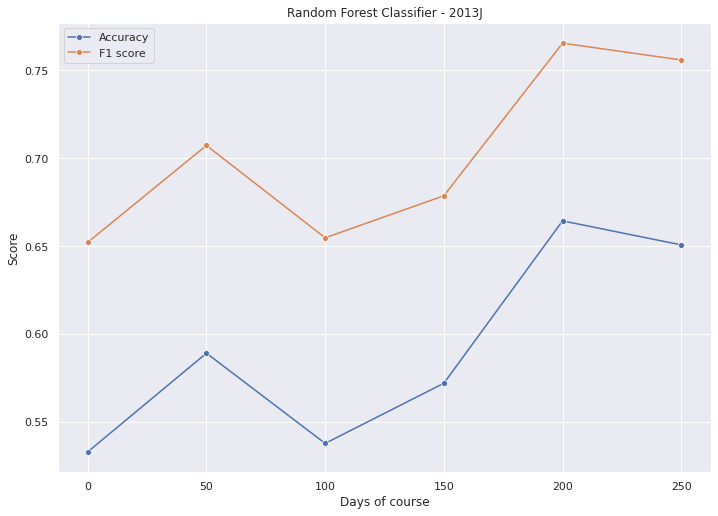

In [354]:
plot_days(df.keys(),result, "Random Forest Classifier - 2013J")

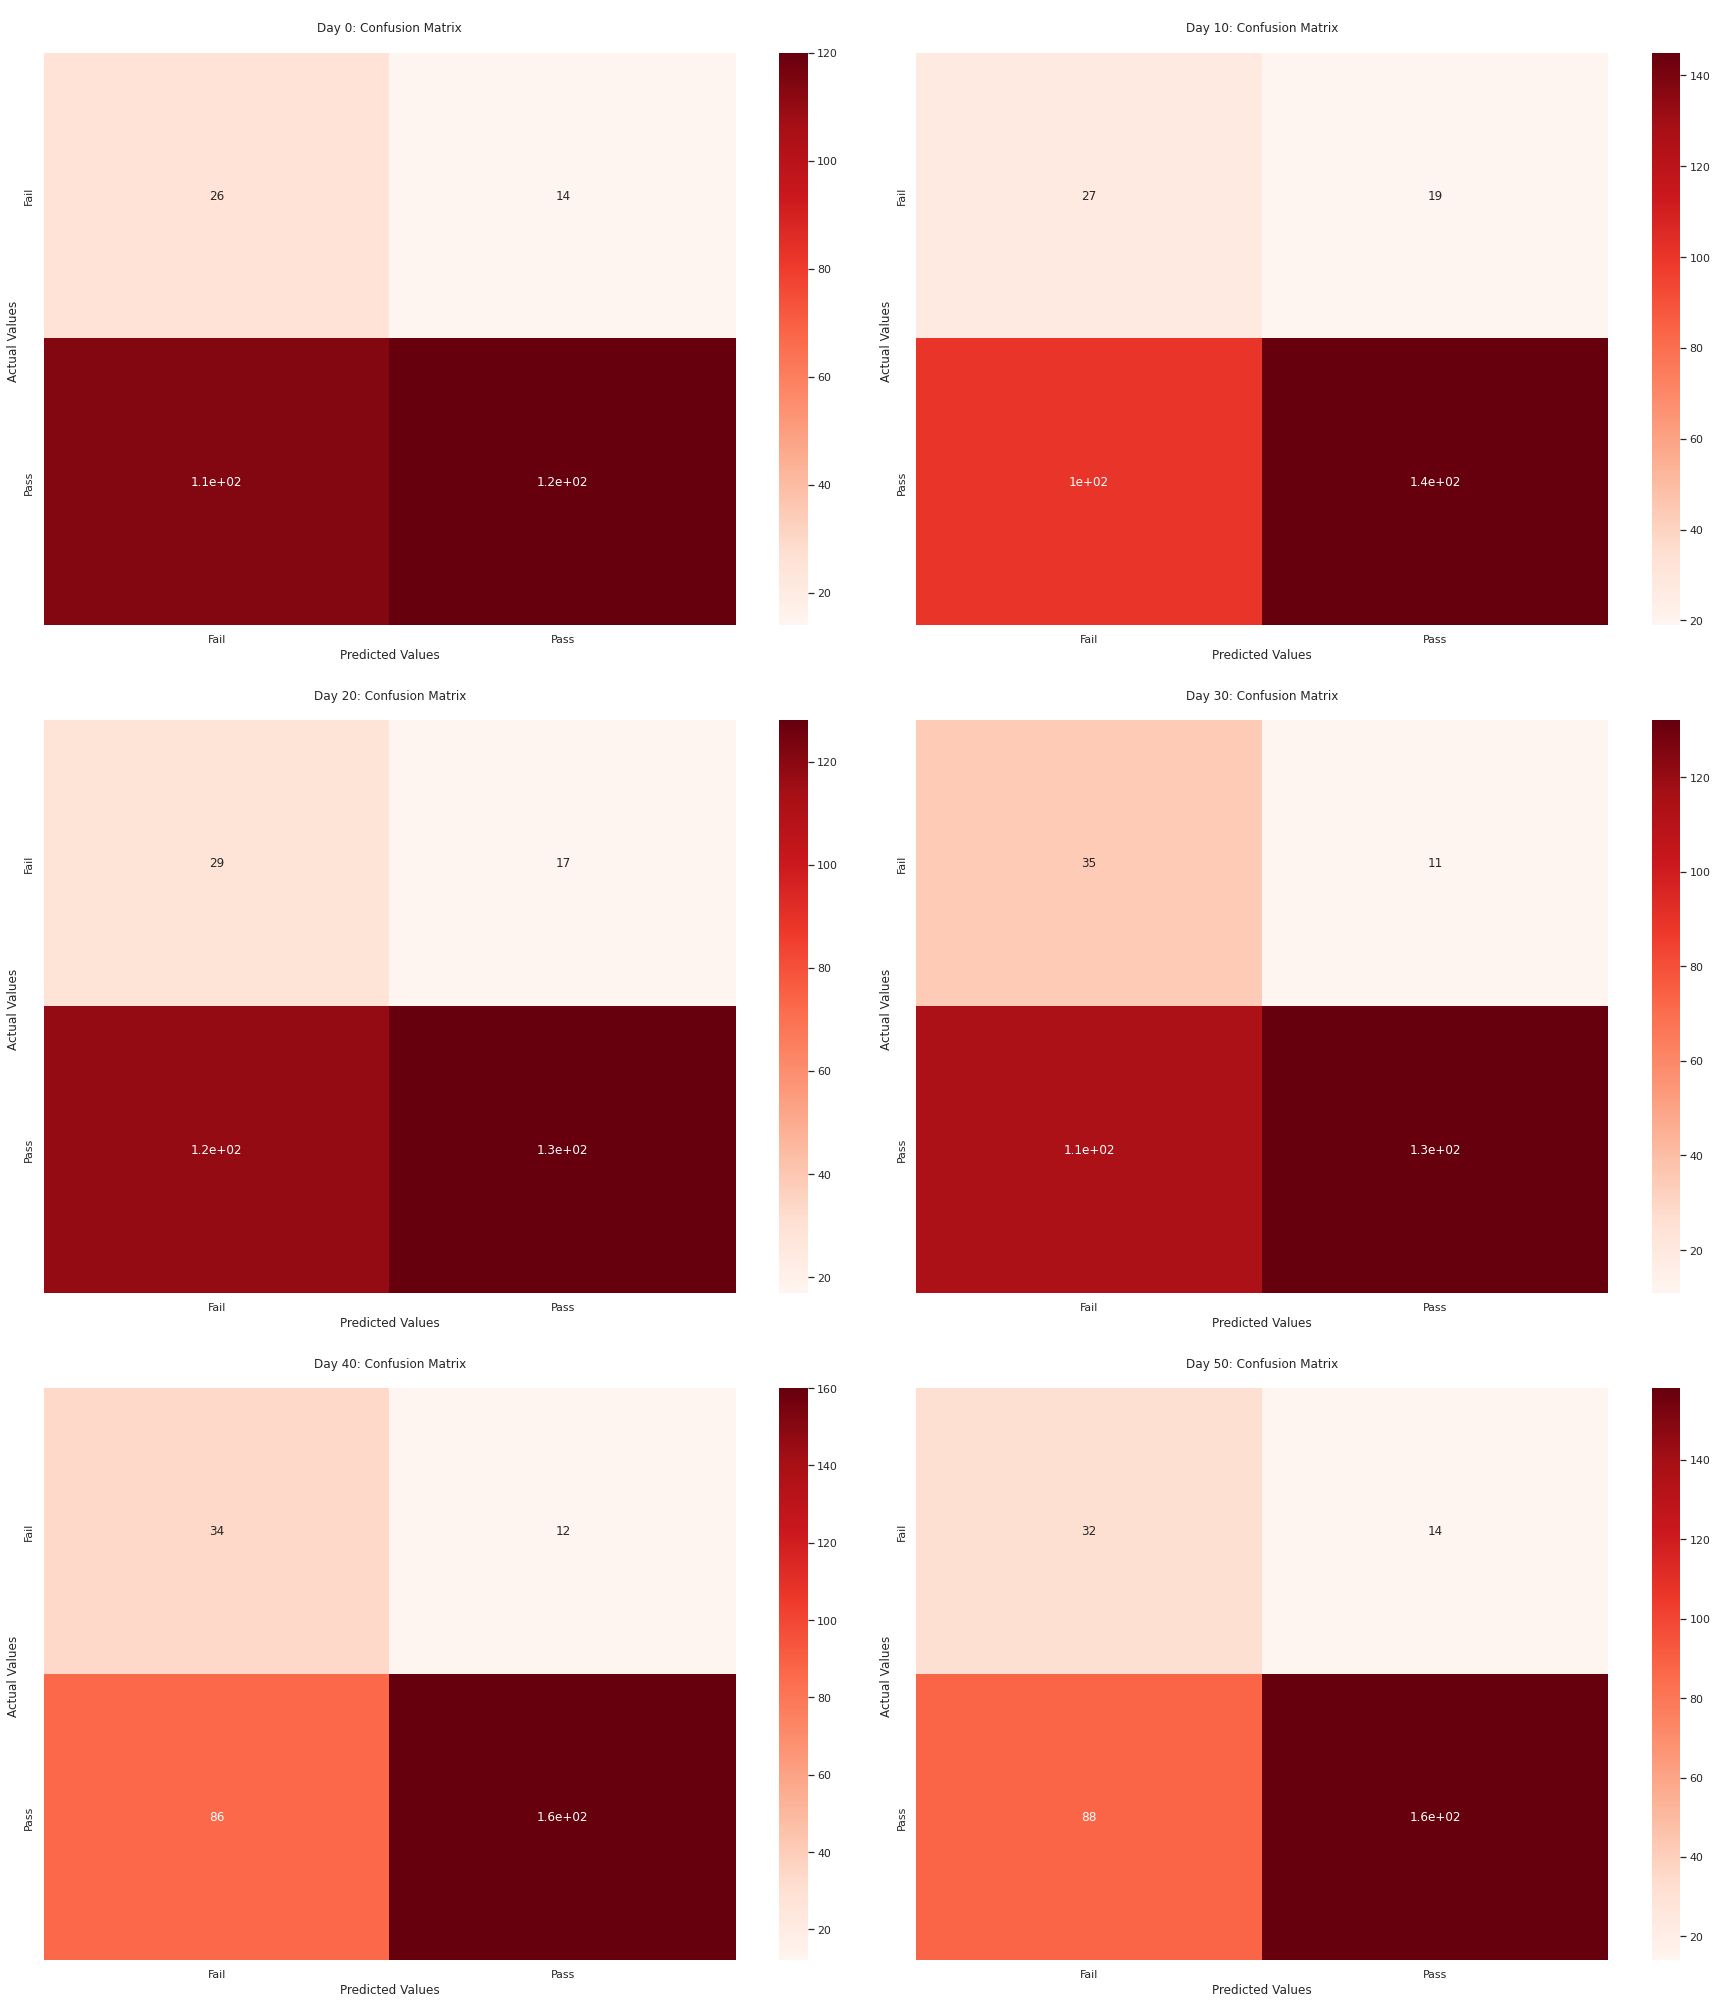

In [355]:
plot_confusion_matrix(result)

In [356]:
# !pip install shap

In [357]:
# import shap 

In [358]:
# shap_values = shap.TreeExplainer(grid_search.best_estimator_).shap_values(X_train_sample[250])
# shap.summary_plot(shap_values, X_train_sample[250])

In [359]:
# explainer = shap.TreeExplainer(grid_search.best_estimator_)

In [360]:
# shap.initjs()

# # Write in a function
# def shap_plot(j):
#   explainerModel = shap.TreeExplainer(grid_search.best_estimator_)
#   shap_values_Model = explainerModel.shap_values(S)
#   p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
#   return(p)

#### Naive Bayes

In [361]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

In [362]:
var_smoothing = [0.0000001, 0.00000001, 0.000000001, 0.00000001]

In [363]:
# Create the random grid
param_grid = {'var_smoothing': var_smoothing}

In [364]:
result = []

##### Day 0

In [365]:
day = 0

###### Grid Search

In [366]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [367]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.62%, F1 Score = 0.74%.
Accuracy = 0.62%, F1 Score = 0.74%.
Improvement of 0.00%.


In [368]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [369]:
nb = GaussianNB(var_smoothing=1e-08)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 0:
Accuracy: 0.6240875912408759, F1 Score: 0.743142144638404, Precision: 0.8922155688622755, Recall: 0.6367521367521367


In [370]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,3.001257e-08,1.000000e+00,1.0
1,2.217970e-02,9.778203e-01,1.0
2,6.263460e-03,9.937365e-01,1.0
3,8.168430e-01,1.831570e-01,1.0
4,3.335250e-07,9.999997e-01,1.0
...,...,...,...
269,1.138804e-03,9.988612e-01,1.0
270,9.999617e-01,3.827191e-05,1.0
271,1.611261e-09,1.000000e+00,1.0
272,0.000000e+00,1.000000e+00,1.0


##### Day 50

In [371]:
day = 50

###### Grid Search

In [372]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [373]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.57%, F1 Score = 0.68%.
Accuracy = 0.57%, F1 Score = 0.68%.
Improvement of 0.00%.


In [374]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [375]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 50:
Accuracy: 0.565068493150685, F1 Score: 0.683291770573566, Precision: 0.8838709677419355, Recall: 0.556910569105691


In [376]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,9.999242e-01,0.000076,1.0
1,9.866638e-01,0.013336,1.0
2,4.126466e-01,0.587353,1.0
3,9.993048e-01,0.000695,1.0
4,2.125426e-07,1.000000,1.0
...,...,...,...
287,4.658980e-01,0.534102,1.0
288,9.999975e-01,0.000003,1.0
289,9.974969e-01,0.002503,1.0
290,0.000000e+00,1.000000,1.0


##### Day 100

In [377]:
day = 100

###### Grid Search

In [378]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [379]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.70%, F1 Score = 0.81%.
Accuracy = 0.69%, F1 Score = 0.81%.
Improvement of -0.99%.


In [380]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [381]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 100:
Accuracy: 0.6883561643835616, F1 Score: 0.8100208768267222, Precision: 0.8326180257510729, Recall: 0.7886178861788617


In [382]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,6.118226e-13,1.000000,1.0
1,5.774735e-08,1.000000,1.0
2,3.796195e-10,1.000000,1.0
3,1.000000e+00,0.000000,1.0
4,2.566022e-13,1.000000,1.0
...,...,...,...
287,8.548693e-06,0.999991,1.0
288,8.594067e-15,1.000000,1.0
289,1.000000e+00,0.000000,1.0
290,0.000000e+00,1.000000,1.0


##### Day 150

In [383]:
day = 150

###### Grid Search

In [384]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [385]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.62%, F1 Score = 0.74%.
Accuracy = 0.62%, F1 Score = 0.74%.
Improvement of 0.00%.


In [386]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [387]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 150:
Accuracy: 0.6164383561643836, F1 Score: 0.7407407407407407, Precision: 0.8602150537634409, Recall: 0.6504065040650406


In [388]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,7.454498e-14,1.000000e+00,1.0
1,9.199902e-04,9.990800e-01,1.0
2,1.206459e-03,9.987935e-01,1.0
3,9.999986e-01,1.370400e-06,1.0
4,7.780134e-08,9.999999e-01,1.0
...,...,...,...
287,7.770773e-01,2.229227e-01,1.0
288,1.774590e-14,1.000000e+00,1.0
289,9.999991e-01,8.875451e-07,1.0
290,0.000000e+00,1.000000e+00,1.0


##### Day 200

In [389]:
day = 200

###### Grid Search

In [390]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [391]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.72%, F1 Score = 0.82%.
Accuracy = 0.72%, F1 Score = 0.82%.
Improvement of 0.00%.


In [392]:
nb_random.best_params_

{'var_smoothing': 1e-09}

###### Prediction

In [393]:
nb = GaussianNB(var_smoothing=1e-08)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 200:
Accuracy: 0.6986301369863014, F1 Score: 0.8018018018018018, Precision: 0.898989898989899, Recall: 0.7235772357723578


In [394]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,1.046384e-06,0.999999,1.0
1,9.981647e-05,0.999900,1.0
2,8.245353e-04,0.999175,1.0
3,9.026033e-01,0.097397,1.0
4,6.739126e-10,1.000000,1.0
...,...,...,...
287,9.972060e-01,0.002794,1.0
288,1.132693e-06,0.999999,1.0
289,9.687133e-01,0.031287,1.0
290,2.536485e-01,0.746351,1.0


##### Day 250

In [395]:
day = 250

###### Grid Search

In [396]:
nb = GaussianNB()
nb_random = GridSearchCV(estimator = nb, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
nb_random.fit(X_train_sample[day], Y_train_sample[day])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-08]},
             verbose=2)

In [397]:
print('Model Performance:')

base_model = GaussianNB()
base_model.fit(X_train_sample[day], Y_train_sample[day])
base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

best_random = nb_random.best_estimator_
random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Accuracy = 0.38%, F1 Score = 0.45%.
Accuracy = 0.41%, F1 Score = 0.50%.
Improvement of 10.00%.


In [398]:
nb_random.best_params_

{'var_smoothing': 1e-07}

###### Prediction

In [399]:
nb = GaussianNB(var_smoothing=1e-07)

nb.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_naivebayes_predictions = nb.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_naivebayes_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 250:
Accuracy: 0.4143835616438356, F1 Score: 0.5043478260869565, Precision: 0.8787878787878788, Recall: 0.35365853658536583


In [400]:
pd.DataFrame(np.column_stack((nb.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,6.346491e-07,9.999994e-01,1.0
1,9.987207e-01,1.279271e-03,1.0
2,9.961135e-01,3.886479e-03,1.0
3,1.000000e+00,2.510656e-19,1.0
4,1.000000e+00,2.995680e-11,1.0
...,...,...,...
287,9.997128e-01,2.872303e-04,1.0
288,1.706639e-08,1.000000e+00,1.0
289,1.000000e+00,1.360813e-19,1.0
290,0.000000e+00,1.000000e+00,1.0


##### Overall Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


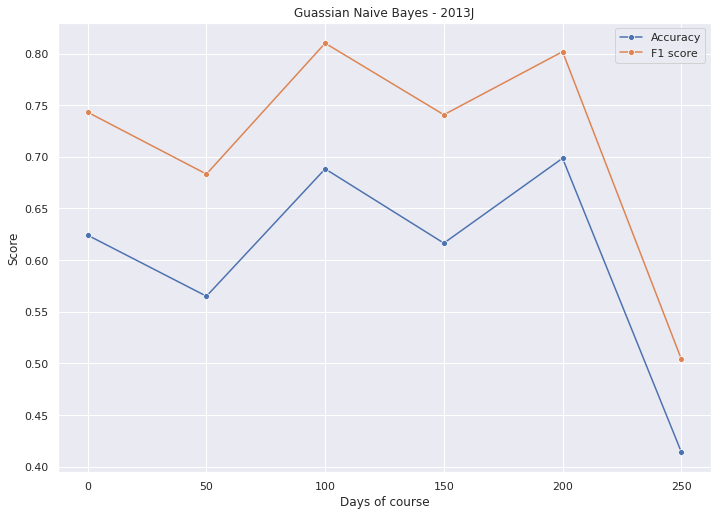

In [401]:
plot_days(df.keys(),result, "Guassian Naive Bayes - 2013J")

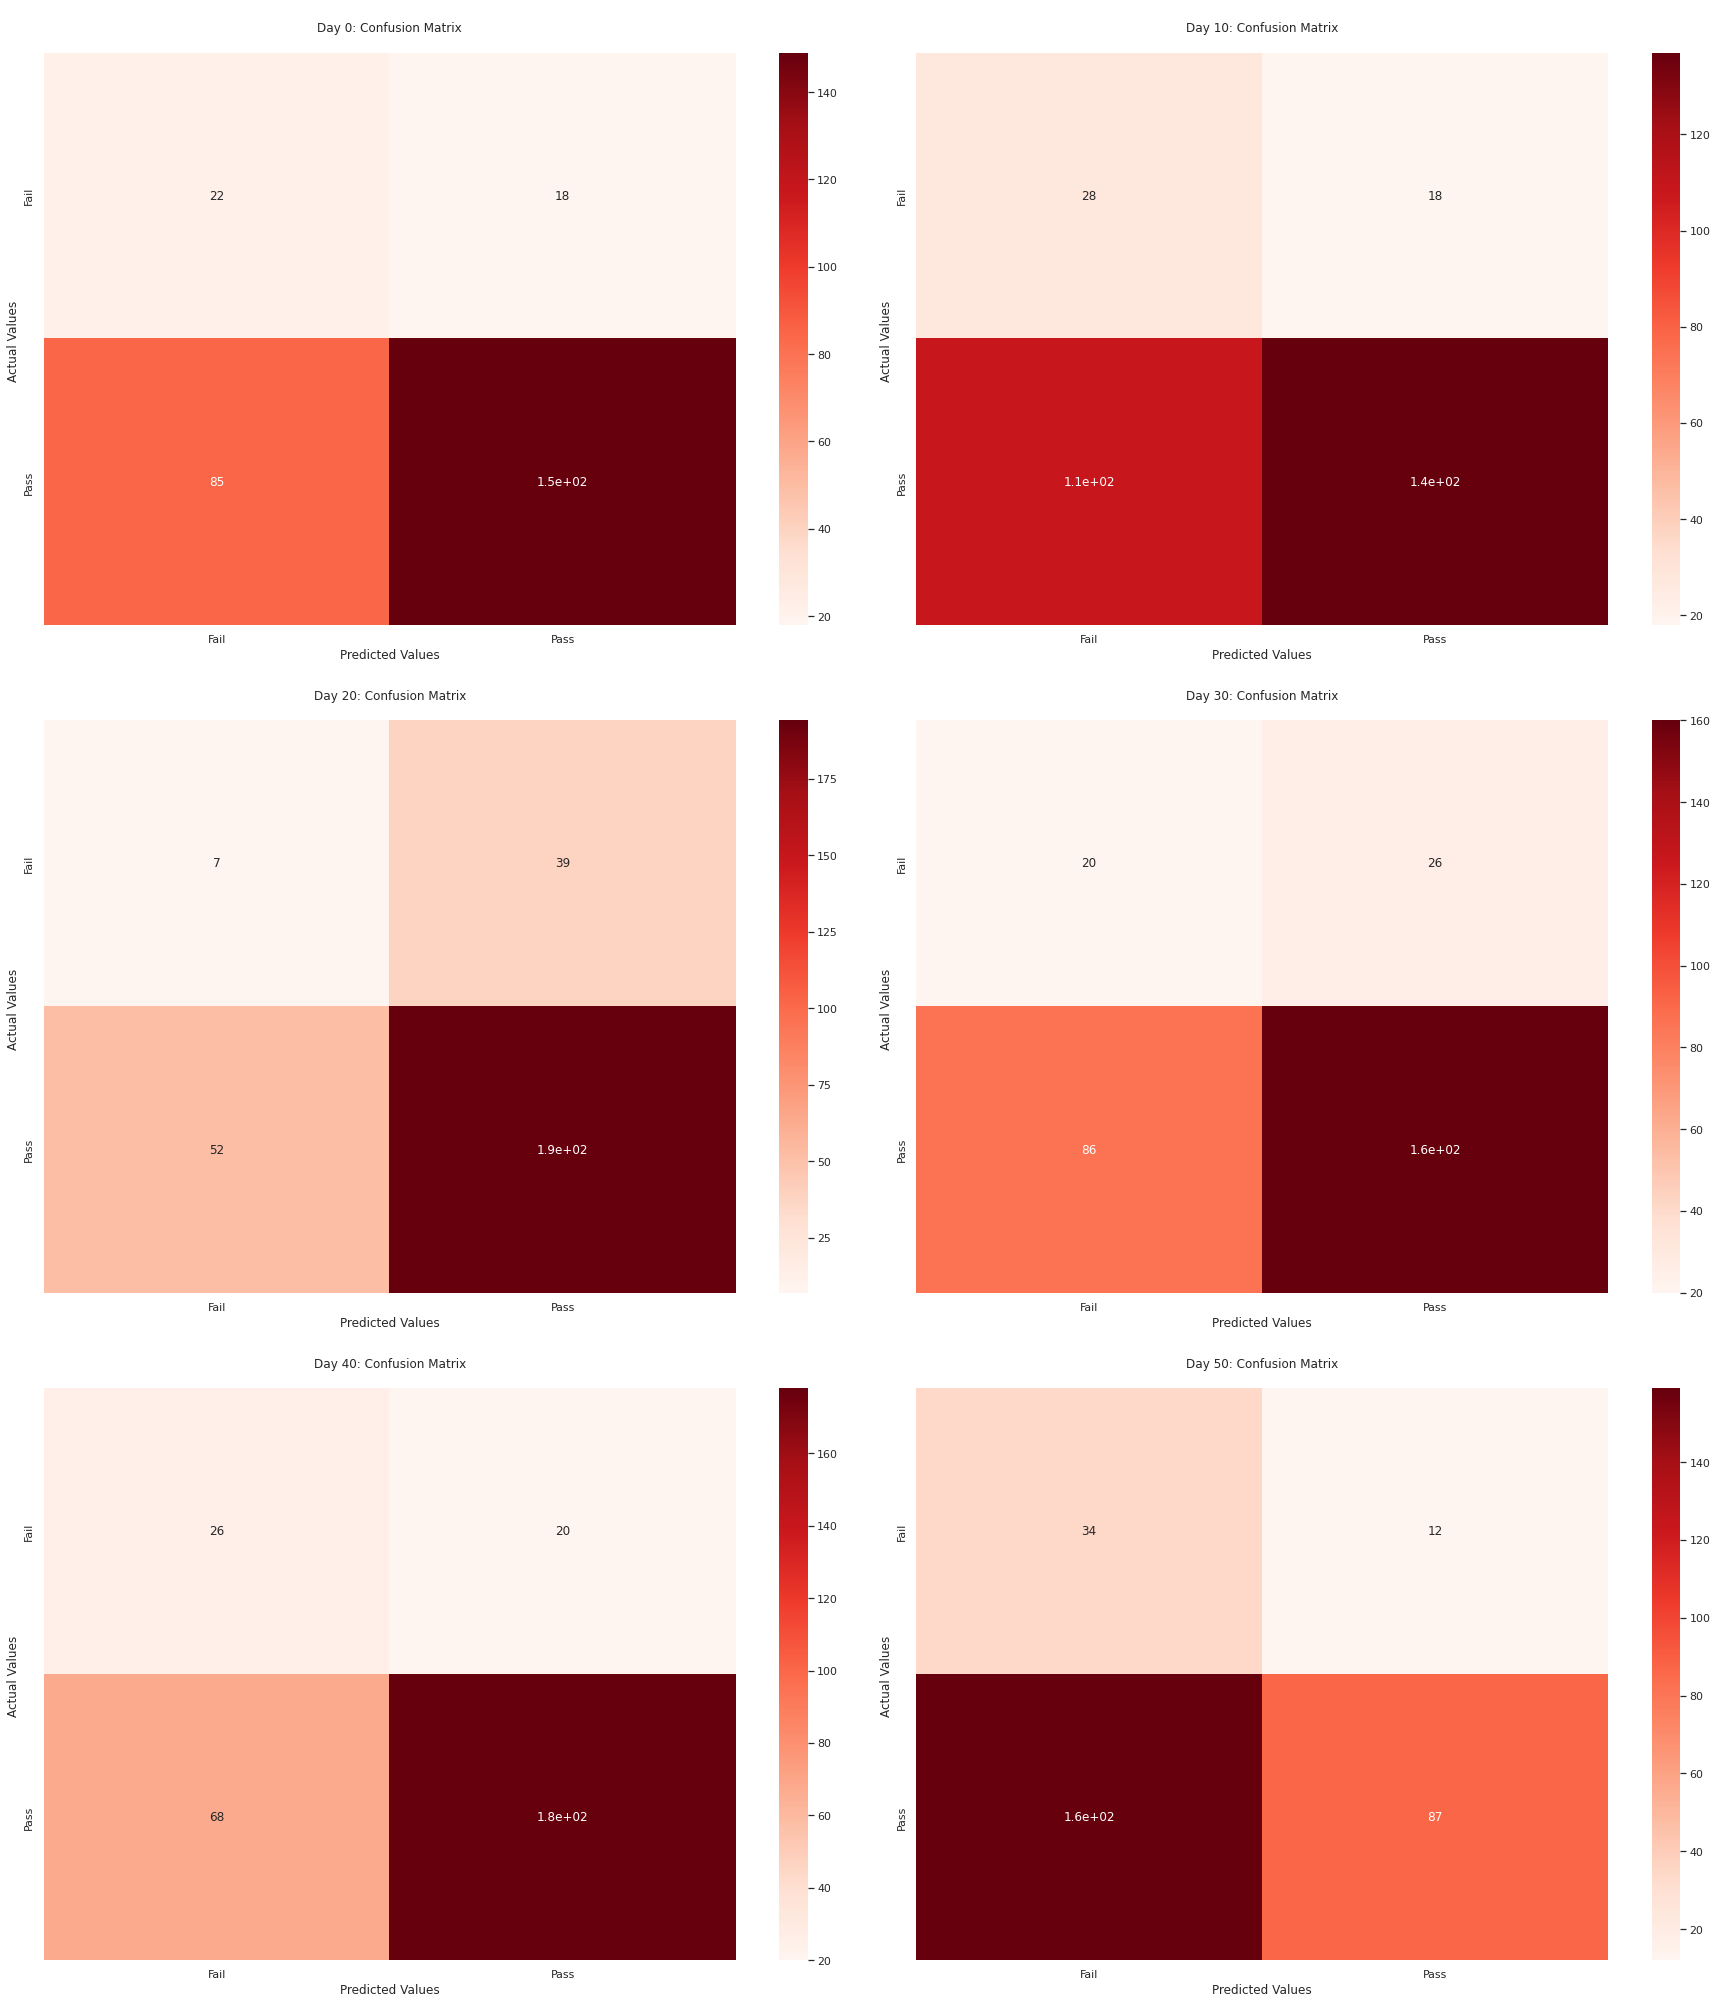

In [402]:
plot_confusion_matrix(result)

#### K-Nearest Neighbors

In [403]:
from sklearn.neighbors import KNeighborsClassifier

In [404]:
leaf_size = list(range(1,50, 2))
n_neighbors = list(range(1,31))
p=[1,2]

In [405]:
#Create the random grid
param_grid = {'leaf_size': leaf_size,
              'n_neighbors': n_neighbors,
              'p': p}


# param_grid = {'n_neighbors': n_neighbors}

In [406]:
result = []

##### Day 0

In [407]:
day = 0

###### Random Search

In [408]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [409]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [410]:
# knn_random.best_params_

###### Prediction

In [411]:
knn = KNeighborsClassifier()

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 0:
Accuracy: 0.635036496350365, F1 Score: 0.7560975609756098, Precision: 0.8806818181818182, Recall: 0.6623931623931624


In [412]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.0,1.0,1.0
1,0.8,0.2,1.0
2,0.2,0.8,1.0
3,0.4,0.6,1.0
4,0.6,0.4,1.0
...,...,...,...
269,0.2,0.8,1.0
270,0.2,0.8,1.0
271,0.2,0.8,1.0
272,0.2,0.8,1.0


##### Day 50

In [413]:
day = 50

###### Random Search

In [414]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [415]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [416]:
# knn_random.best_params_

###### Prediction

In [417]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=8, p=1)

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 50:
Accuracy: 0.5821917808219178, F1 Score: 0.6934673366834171, Precision: 0.9078947368421053, Recall: 0.5609756097560976


In [418]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.375,0.625,1.0
1,0.625,0.375,1.0
2,0.500,0.500,1.0
3,0.375,0.625,1.0
4,0.250,0.750,1.0
...,...,...,...
287,0.625,0.375,1.0
288,0.375,0.625,1.0
289,0.250,0.750,1.0
290,0.500,0.500,1.0


##### Day 100

In [419]:
day = 100

###### Random Search

In [420]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [421]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [422]:
# knn_random.best_params_

###### Prediction

In [423]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=21, p=2)

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 100:
Accuracy: 0.6917808219178082, F1 Score: 0.7982062780269058, Precision: 0.89, Recall: 0.7235772357723578


In [424]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.333333,0.666667,1.0
1,0.571429,0.428571,1.0
2,0.333333,0.666667,1.0
3,0.476190,0.523810,1.0
4,0.333333,0.666667,1.0
...,...,...,...
287,0.380952,0.619048,1.0
288,0.238095,0.761905,1.0
289,0.428571,0.571429,1.0
290,0.476190,0.523810,1.0


##### Day 150

In [425]:
day = 150

###### Random Search

In [426]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [427]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [428]:
# knn_random.best_params_

###### Prediction

In [429]:
knn = KNeighborsClassifier()

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 150:
Accuracy: 0.6472602739726028, F1 Score: 0.7565011820330968, Precision: 0.903954802259887, Recall: 0.6504065040650406


In [430]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.4,0.6,1.0
1,0.8,0.2,1.0
2,0.6,0.4,1.0
3,0.0,1.0,1.0
4,0.6,0.4,1.0
...,...,...,...
287,0.4,0.6,1.0
288,0.4,0.6,1.0
289,0.4,0.6,1.0
290,0.4,0.6,1.0


##### Day 200

In [431]:
day = 200

###### Random Search

In [432]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [433]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [434]:
# knn_random.best_params_

###### Prediction

In [435]:
knn = KNeighborsClassifier()

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 200:
Accuracy: 0.6541095890410958, F1 Score: 0.7623529411764706, Precision: 0.9050279329608939, Recall: 0.6585365853658537


In [436]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.4,0.6,1.0
1,0.8,0.2,1.0
2,0.6,0.4,1.0
3,0.2,0.8,1.0
4,1.0,0.0,1.0
...,...,...,...
287,0.4,0.6,1.0
288,0.4,0.6,1.0
289,0.4,0.6,1.0
290,0.4,0.6,1.0


##### Day 250

In [437]:
day = 250

###### Random Search

In [438]:
# knn = KNeighborsClassifier()
# knn_random = GridSearchCV(estimator = knn, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
# knn_random.fit(X_train_sample[day], Y_train_sample[day])

In [439]:
# print('Model Performance:')

# base_model = KNeighborsClassifier()
# base_model.fit(X_train_sample[day], Y_train_sample[day])
# base_accuracy = evaluate_search(base_model, X_test[day], Y_test[day])

# best_random = knn_random.best_estimator_
# random_accuracy = evaluate_search(best_random, X_test[day], Y_test[day])

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [440]:
# knn_random.best_params_

###### Prediction

In [441]:
knn = KNeighborsClassifier(leaf_size=1, n_neighbors=7, p=2)

knn.fit(X_train_sample[day], Y_train_sample[day])

print(f"Day {day}:")

test_knearestneighbors_predictions = knn.predict(X_test[day])

acc, f1, prec, recall, conf = evaluation_summary(test_knearestneighbors_predictions, Y_test[day])
print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
result.append([acc, f1, prec, recall, conf])

Day 250:
Accuracy: 0.7363013698630136, F1 Score: 0.8315098468271335, Precision: 0.9004739336492891, Recall: 0.7723577235772358


In [442]:
pd.DataFrame(np.column_stack((knn.predict_proba(X_test[day]), Y_test[day].to_numpy())))

,0,1,2
0,0.285714,0.714286,1.0
1,0.714286,0.285714,1.0
2,0.428571,0.571429,1.0
3,0.285714,0.714286,1.0
4,0.714286,0.285714,1.0
...,...,...,...
287,0.285714,0.714286,1.0
288,0.285714,0.714286,1.0
289,0.428571,0.571429,1.0
290,0.428571,0.571429,1.0


##### Overall Predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


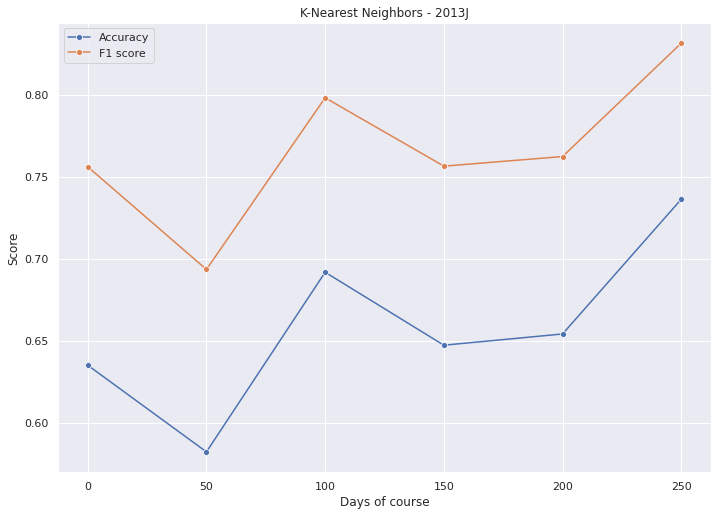

In [443]:
plot_days(df.keys(),result, "K-Nearest Neighbors - 2013J")

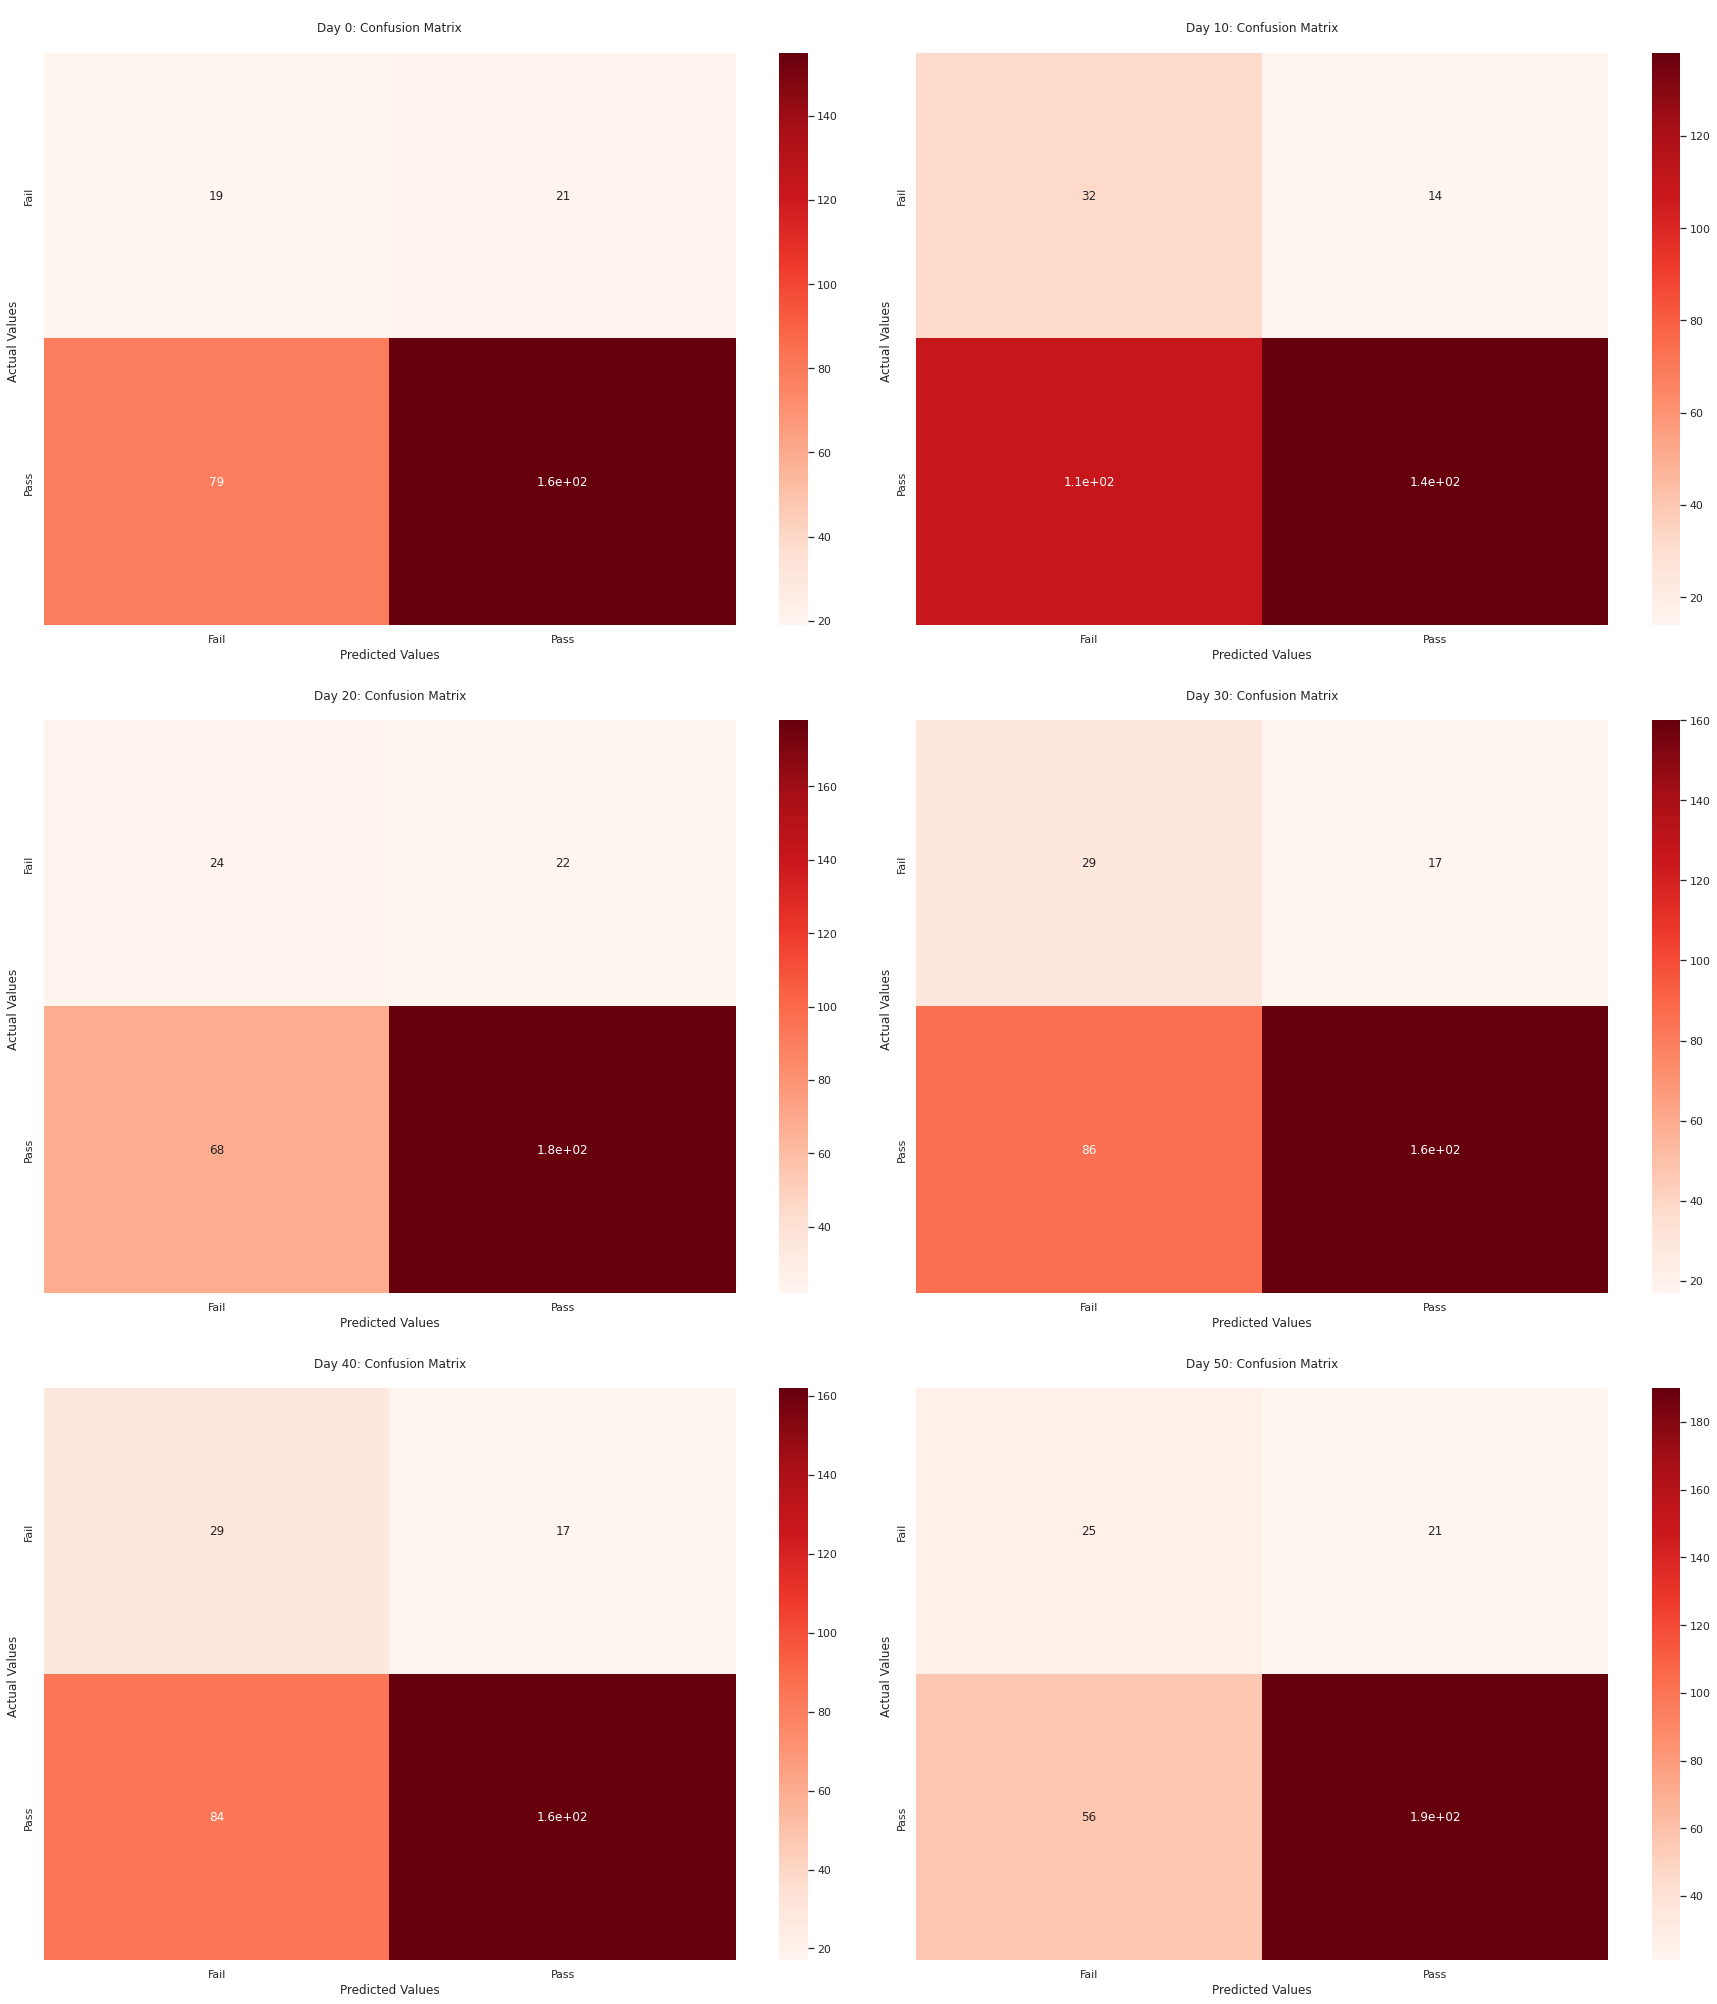

In [444]:
plot_confusion_matrix(result)

## Drop in user clicks

In [445]:
df[1].loc[df[1]['code_presentation']=="2013J"]

KeyError: ignored

In [ ]:
df_cp = df[0].loc[df[0]['code_presentation']=="2013J"]
df_cp = df_cp[["id_student"]]
df_cp['final_result'] = df[0].loc[df[0]['code_presentation']=="2013J"].final_result.replace({1:0, 2:1, 3:1})

for i in range(len(df)):
  df_cp[f'mean_click_{i}'] = df[i].loc[df[i]['code_presentation']=="2013J"].mean_click

In [ ]:
df_cp

### Drop in last weeks user clicks

In [ ]:
PERCENT_DROP = 10

def drop_previous_week(row, week):
  prev_week = row[f'mean_click_{week-1}']
  curr_week = row[f'mean_click_{week}']
  percent_drop_week = ((prev_week-curr_week)/abs(prev_week))*100

  if percent_drop_week >= PERCENT_DROP:
    significant_drop = True
  else:
    significant_drop = False

  #print(prev_week, curr_week, significant_drop, percent_drop_week,row['final_result'])

  return significant_drop#, row['final_result']

#print("prev_week", "curr_week", "significant_drop", "percent_drop_week", "final_result")

drop_df = df_cp[['id_student','final_result']]
for week in range(1, len(df)):
  drop_df[f'week_{week*10}'] = df_cp.apply(lambda row : drop_previous_week(row, week), axis=1)

In [ ]:
drop_df

In [ ]:
drop_df.loc[drop_df['final_result'] == 0]

### Difference in user clicks on class average clicks from that week

In [ ]:
PERCENT_DIFF = 10

def diff_class_average(row, class_average, week):
  curr_week_avg = row[f'mean_click_{week}']

  percent_diff_week = ((class_average-curr_week_avg)/abs(class_average))*100


  if percent_diff_week >= PERCENT_DIFF:
    significant_diff = True
  else:
    significant_diff = False

  # if row['final_result'] == 1.0:
  #   print(curr_week_avg, significant_drop,percent_diff_week, row['final_result'])

  return significant_diff


diff_df = df_cp[['id_student','final_result']]
for week in range(0, len(df)):
  class_average = df_cp[f'mean_click_{week}'].mean()
  diff_df[f'week_{week*10}'] = df_cp.apply(lambda row : diff_class_average(row, class_average, week), axis=1)  

In [ ]:
diff_df

In [ ]:
diff_df.loc[diff_df['final_result'] == 0]

In [ ]:
# from sklearn.inspection import permutation_importance

# importance = permutation_importance(randomforest, X_test, Y_test)
# print(importance.importances_mean)

# feature_names = randomforest.feature_names_in_

# plt.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
# plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
# plt.show()

# importance_table = pd.DataFrame({'importance': importance['importances_mean'],
#                                  'column': feature_names })
# importance_table.sort_values(by = 'importance', ascending = False)[:20]